In [ ]:
from tqdm.notebook import tqdm


In [ ]:
conda install jupyterlab=2.1.5 ipympl==0.5.6   
Loading widget

In [1]:
from random import randint
from transformers import FlavaProcessor, FlavaModel
import torch
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import BlipProcessor
from dataclasses import dataclass
from transformers import FlavaProcessor, FlavaForPreTraining
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from pyexpat import features
import copy
import math
from sys import prefix
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from transformers import BlipModel, AutoConfig, AutoModel
import torchmetrics
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import FlavaModel, FlavaProcessor
import copy
import os
import gzip
import json
import pandas as pd
# import matplotlib.pyplot as plt
import shutil
import warnings
warnings.filterwarnings('ignore')
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AdamW
from sklearn.metrics import accuracy_score


In [2]:
import os
os.environ['http_proxy'] = "http://sysproxy.wal-mart.com:8080"
os.environ['https_proxy'] = "http://sysproxy.wal-mart.com:8080"
os.environ['NO_PROXY'] = "*.walmart.com,*.wal-mart.com,*.walmart.net,*.wal-mart.net,localhost,127.0.0.1"
os.environ['NO_PROXY'] = \
"*.walmart.com*.wal-mart.com*.walmart.net*.wal-mart.netlocalhost127.0.0.1.cdn-lfs.hf.co.api.agentops.ai"
os.environ["SSL_CERT_FILE"] = '/etc/ssl/certs/ca-certificates.crt'
# os.environ['SSL_CERT_FILE'] = '/etc/ssl/certs/ca-bundle.crt'
os.environ["REQUESTS_CA_BUNDLE"] = '/etc/ssl/certs/ca-certificates.crt'
# os.environ['no_proxy'] = "cdn-lfs.hf.co"
# os.environ['no_proxy'] = "*.wal-mart.com,*.walmart.com,*.walmart.net,*.wal-mart.net"
# os.environ['no_proxy'] = "cdn-lfs.hf.co"



In [7]:
# import urllib.request

# url = "https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-images-small.tar"
# filename = "abo-images-small.tar"

# urllib.request.urlretrieve(url, filename)

('abo-images-small.tar', <http.client.HTTPMessage at 0x7fc9b8cfe7d0>)

In [8]:
# import urllib.request

# url = "https://amazon-berkeley-objects.s3.amazonaws.com/archives/abo-listings.tar"
# filename = "abo-listings.tar"

# urllib.request.urlretrieve(url, filename)

('abo-listings.tar', <http.client.HTTPMessage at 0x7fc9ab5c4d90>)

In [ ]:

     
shutil.unpack_archive("/data/Kishore/Major/abo-images-small.tar", "/data/Kishore/Major/abo-images-small")

In [ ]:
shutil.unpack_archive("/data/Kishore/Major/abo-listings.tar", "/data/Kishore/Major/abo-listings")

In [3]:
# Path to the folder containing .json.gz files
folder_path = '/data/Kishore/Major/abo-listings/listings/metadata'
data_dict = dict()
# Iterate through all the files in the folder
for file_name in os.listdir(folder_path):
    if file_name.endswith('.json.gz'):  # Check if the file is a .json.gz file
        file_path = os.path.join(folder_path, file_name)

        # Open and read the gzipped JSON file line by line
        with gzip.open(file_path, 'rt', encoding='utf-8') as gz_file:
            print(f"Reading file: {file_name}")
            for idx , line in enumerate(gz_file):  # Read each line
                try:
                    data = json.loads(line)  # Load each line as a separate JSON object
                    for item_name in data['item_name'] :
                      if('en_' in item_name['language_tag']) :
                        data_dict[f"{file_name}_{idx}"] = dict()
                        data_dict[f"{file_name}_{idx}"]["product_name"] = item_name['value']
                        data_dict[f"{file_name}_{idx}"]["hierarchy"] = data.get('node',None)
                        all_image_id = [data.get('main_image_id',None)]
                        if data.get('other_image_id',None) :
                          pass
                          # all_image_id.extend(data.get('other_image_id',None))
                        data_dict[f"{file_name}_{idx}"]["image_id"] = all_image_id
                except json.JSONDecodeError as e:
                    print(f"Could not parse JSON in file {file_name}: {e}")

Reading file: listings_f.json.gz
Reading file: listings_e.json.gz
Reading file: listings_d.json.gz
Reading file: listings_c.json.gz
Reading file: listings_b.json.gz
Reading file: listings_a.json.gz
Reading file: listings_9.json.gz
Reading file: listings_8.json.gz
Reading file: listings_7.json.gz
Reading file: listings_6.json.gz
Reading file: listings_5.json.gz
Reading file: listings_4.json.gz
Reading file: listings_3.json.gz
Reading file: listings_2.json.gz
Reading file: listings_1.json.gz
Reading file: listings_0.json.gz


In [4]:
all_data = []
for key in data_dict.keys() :
    d = data_dict[key]
    d['key'] = key
    all_data.append(d)

ecomm_data = pd.DataFrame((all_data))
ecomm_data = ecomm_data.explode('image_id')
ecomm_data = ecomm_data.dropna()
ecomm_data.drop(columns = ['key'],inplace = True)
ecomm_data["clean_hierarchy"] = ecomm_data.hierarchy.apply(lambda x : x[-1]['node_name'])
ecomm_data = ecomm_data.dropna()
ecomm_data = ecomm_data[ecomm_data.clean_hierarchy.str.find('カテゴリー別') == -1]
ecomm_data["target_class"] = ecomm_data.clean_hierarchy.apply(lambda text :  text.split("/")[-2])
ecomm_data = ecomm_data[ecomm_data['target_class'] != ""]

ecomm_data_agg = ecomm_data.groupby('target_class').agg({'target_class':'count'}).rename(columns = {'target_class':'count'}).reset_index()
target_class_list = ecomm_data_agg[ecomm_data_agg['count'] > 222].target_class.unique()

ecomm_data = ecomm_data[ecomm_data.target_class.isin(target_class_list)]

ecomm_data_rest = ecomm_data[ecomm_data.target_class != 'Cases & Covers']
ecomm_data_cc = ecomm_data[ecomm_data.target_class == 'Cases & Covers']

ecomm_data = pd.concat([ecomm_data_rest,ecomm_data_cc.sample(3000)]).reset_index(drop =True)


image_metadata = pd.read_csv("/data/Kishore/Major/abo-images-small/images/metadata/images.csv.gz")
ecomm_data_final = pd.merge(ecomm_data,image_metadata[['image_id','path']],on = 'image_id',how = 'inner')

In [5]:
print(ecomm_data_final.shape, ecomm_data_final.target_class.nunique())
ecomm_data_final.head()


(25037, 6) 34


,product_name,hierarchy,image_id,clean_hierarchy,target_class,path
0,"Thirty Five Kent Men's Cashmere Zig Zag Scarf,...","[{'node_id': 10287217011, 'node_name': '/Categ...",81agKrncxwL,/Categories/Men/Clothing,Men,39/39c3dd60.jpg
1,Teen Mix By Catwalk Women's Pink Fashion Slipp...,"[{'node_id': 1983639031, 'node_name': '/Catego...",81oct5RNPzL,/Categories/Shoes/Women's Shoes/Fashion Slippers,Women's Shoes,04/04e7dc58.jpg
2,Amazon Brand - Solimo Designer Leather Texture...,"[{'node_id': 1389409031, 'node_name': '/Catego...",71Qv6mabxdL,/Categories/Mobiles & Accessories/Mobile Acces...,Mobile Accessories,7b/7bcc397a.jpg
3,"AmazonBasics LED GU5.3 MR16 Spotlight Bulb, 4....","[{'node_id': 2314207011, 'node_name': '/Catego...",71jIZHHhUTL,/Categories/Light Bulbs/LED Bulbs,Light Bulbs,57/57bd086c.jpg
4,Amazon Brand - Symbol Men's Navy Canvas Sneake...,"[{'node_id': 1983577031, 'node_name': '/Catego...",81lzP1TfGmL,/Categories/Shoes/Men's Shoes/Casual Shoes/Sne...,Casual Shoes,29/29ed0870.jpg


In [6]:
ecomm_data_final.target_class.value_counts()


target_class
Cases & Covers                     3000
Shoes                              2878
Living Room Furniture              1949
Casual Shoes                       1808
Men's Shoes                        1753
Women                              1364
Categories                          946
Mobile Accessories                  912
Sports & Outdoor Shoes              885
Women's Shoes                       691
Jewelry                             633
Accessories                         622
Men                                 581
Sandals                             510
Tables                              487
Sheets & Pillowcases                465
Handbags                            383
Hats & Caps                         363
Kitchen & Dining Room Furniture     363
Home Bar Furniture                  362
Accent Furniture                    361
Lamps & Shades                      355
Rings                               349
Light Bulbs                         334
Earrings                   

In [7]:
ecomm_data_final.isnull().sum()


product_name       0
hierarchy          0
image_id           0
clean_hierarchy    0
target_class       0
path               0
dtype: int64

Sample Data point : 


{'product_name': 'AmazonBasics 32 Oz Bottle Label, Multi-Purpose Cleaner, Lavender, 5-Pack',
 'hierarchy': [{'node_id': 2224149011,
   'node_name': '/Categories/Garden Structures & Germination Equipment'}],
 'image_id': '51HwfW8BZBL',
 'clean_hierarchy': '/Categories/Garden Structures & Germination Equipment',
 'target_class': 'Categories',
 'path': 'aa/aac0a59b.jpg'}

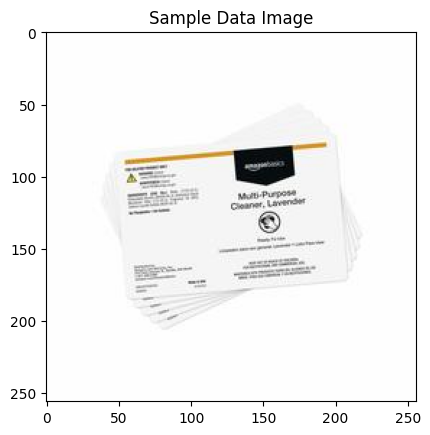

In [8]:
sample_data = ecomm_data_final.to_dict(orient = 'records')[randint(0,len(ecomm_data_final))]
img = plt.imread(f"/data/Kishore/Major/abo-images-small/images/small/{sample_data['path']}")
plt.title(f"{sample_data['product_name'],sample_data['hierarchy'][-1]['node_name']}")
plt.title("Sample Data Image")
plt.imshow(img)
print("Sample Data point : ")
sample_data


In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

strat_column = 'target_class'
train_size = 0.7
val_size = 0.15
test_size = 0.15

label_encoder = LabelEncoder()
ecomm_data_final['label'] = label_encoder.fit_transform(ecomm_data_final[strat_column])

train_data, temp_data = train_test_split(ecomm_data_final,
                                         stratify=ecomm_data_final[strat_column],
                                         test_size=(val_size + test_size),
                                         random_state=42)

val_data, test_data = train_test_split(temp_data,
                                       stratify=temp_data[strat_column],
                                       test_size=test_size/(test_size + val_size),
                                       random_state=42)

train_data['split'] = 'train'
val_data['split'] = 'validation'
test_data['split'] = 'test'

ecomm_data_final = pd.concat([train_data, val_data, test_data])

print(ecomm_data_final['split'].value_counts())

split
train         17525
validation     3756
test           3756
Name: count, dtype: int64


In [10]:
ecomm_data_final.to_csv("data.csv",index = False)
ecomm_data_final.label.min(),ecomm_data_final.label.max(), ecomm_data_final.target_class.nunique()


(0, 33, 34)

In [13]:
# check = FlavaModel.from_pretrained("facebook/flava-full")

In [18]:
# check

FlavaModel(
  (text_model): FlavaTextModel(
    (embeddings): FlavaTextEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): FlavaEncoder(
      (layer): ModuleList(
        (0-11): 12 x FlavaLayer(
          (attention): FlavaAttention(
            (attention): FlavaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): FlavaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=

In [24]:
class EcommerceDataset(Dataset):
    def __init__(self, root_folder = "/home/jupyter/Kishore/IITJ/Semester_2/Foundational Models/Project", image_folder = "/data/Kishore/Major/abo-images-small/images/small/", split='train', image_size=224):
        super(EcommerceDataset, self).__init__()
        self.root_folder = root_folder
        self.image_folder = image_folder
        self.split = split
        self.image_size = image_size
        self.info_file = os.path.join(root_folder, 'data.csv')
        self.df = pd.read_csv(self.info_file)
        self.df = self.df[self.df['split'] == self.split].reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        item = {}
        image_path = row['path']
        item['image'] = Image.open(f"{self.image_folder}/{image_path}").convert('RGB').resize((self.image_size, self.image_size))
        item['text'] = row['product_name']
        item['labels'] = row['label']
        return item
    
@dataclass
class Arguments:
    flava_pretrained_model = 'facebook/flava-full'
    image_size = 224
    batch_size = 32
    num_cpus = os.cpu_count()
    use_pretrained_map = False
    num_mapping_layers = 1
    map_dim = 256
#     fusion = 'concat'
    fusion = 'cross'
    num_pre_output_layers = 3
    lr = 0.01
    weight_decay = 1e-3
    weight_image_loss = 0
    weight_text_loss = 0
    weight_super_loss = 0
    drop_probs = [0.1, 0.1, 0.1]
    freeze_image_encoder = True
    freeze_text_encoder = True
    num_class = 34

args = Arguments() 

def load_dataset(args, split):
    image_folder = "/data/Kishore/Major/abo-images-small/images/small/"
    dataset = EcommerceDataset(root_folder='/home/jupyter/Kishore/IITJ/Semester_2/Foundational Models/Project', image_folder=image_folder, split=split, image_size=args.image_size)
    return dataset

dataset_train = load_dataset(args, split='train')
dataset_validation = load_dataset(args, split='validation')
dataset_test = load_dataset(args, split='test')

class CustomCollator(object):
    def __init__(self, args):
        self.args = args
        # Load the FLAVA processor for image and text processing
        self.processor = FlavaProcessor.from_pretrained("facebook/flava-full")

    def __call__(self, batch):
        # Extract images and text data from the batch
        images = [item['image'] for item in batch]
        texts = [item['text'] for item in batch]

        # Process images and text using FLAVA processor
        processed_inputs = self.processor(images=images, text=texts, return_tensors="pt", padding=True, truncation=True)

        # Extract necessary tensors
        pixel_values = processed_inputs['pixel_values']  # Shape: [batch_size, 3, 224, 224]
        input_ids = processed_inputs['input_ids']
        attention_mask = processed_inputs['attention_mask']

        # Collect labels
        labels = torch.LongTensor([item['labels'] for item in batch])

        # Build the final batch dictionary
        batch_new = {
            'pixel_values': pixel_values,
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'labels': labels
        }

        return batch_new

# Initialize the collator with arguments
collator = CustomCollator(args)

train_dataloader = DataLoader(dataset_train, batch_size=args.batch_size, shuffle=True, num_workers=args.num_cpus, collate_fn=collator)
val_dataloader = DataLoader(dataset_validation, batch_size=args.batch_size, shuffle=False, num_workers=args.num_cpus, collate_fn=collator)
test_dataloader = DataLoader(dataset_test, batch_size=args.batch_size, shuffle=False, num_workers=args.num_cpus, collate_fn=collator)

# model = FlavaForPreTraining.from_pretrained("facebook/flava-full")
# model.classifier = torch.nn.Linear(model.config.hidden_size, len(label_encoder.classes_))

# Training setup
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)
# optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
# criterion = torch.nn.CrossEntropyLoss()



class FLAVAClassifier(nn.Module):
    def __init__(self, args):
        super().__init__()
        
        self.num_mapping_layers = args.num_mapping_layers
        self.map_dim = args.map_dim
        self.fusion = args.fusion
        self.num_pre_output_layers = args.num_pre_output_layers
        self.lr = args.lr
        self.weight_decay = args.weight_decay
        self.weight_image_loss = args.weight_image_loss
        self.weight_text_loss = args.weight_text_loss

        # Load the FLAVA model
        self.flava = FlavaModel.from_pretrained(args.flava_pretrained_model)

        
        self.image_encoder = copy.deepcopy(self.flava.image_model)
        self.text_encoder = copy.deepcopy(self.flava.text_model)

        ## Projection Layers
        image_map_layers = [nn.Linear(self.image_encoder.config.hidden_size, self.map_dim), nn.Dropout(p=args.drop_probs[0])]
        text_map_layers = [nn.Linear(self.text_encoder.config.hidden_size, self.map_dim), nn.Dropout(p=args.drop_probs[0])]
        for _ in range(1, self.num_mapping_layers):
            image_map_layers.extend([nn.ReLU(), nn.Linear(self.map_dim, self.map_dim), nn.Dropout(p=args.drop_probs[0])])
            text_map_layers.extend([nn.ReLU(), nn.Linear(self.map_dim, self.map_dim), nn.Dropout(p=args.drop_probs[0])])

        self.image_map = nn.Sequential(*image_map_layers)
        self.text_map = nn.Sequential(*text_map_layers)

        ## Pre Output Layers
        if args.fusion in ['align', 'align_shuffle']:
            pre_output_input_dim = self.map_dim
        elif args.fusion == 'concat':
            pre_output_input_dim = self.map_dim*2
        elif args.fusion.startswith('cross'):
            pre_output_input_dim = self.map_dim**2
        elif args.fusion == 'align_concat':
            pre_output_input_dim = self.map_dim*3
        elif args.fusion == 'attention_m':
            self.gen_query = nn.Linear(self.map_dim, self.map_dim//4)
            self.gen_key = nn.Linear(self.map_dim, self.map_dim//4)
            self.soft = nn.Softmax(dim=1)
            pre_output_input_dim = self.map_dim*2

        pre_output_layers = [nn.Dropout(p=args.drop_probs[1])]
        output_input_dim = pre_output_input_dim
        if self.num_pre_output_layers >= 1: # first pre-output layer
            pre_output_layers.extend([nn.Linear(pre_output_input_dim, self.map_dim), nn.ReLU(), nn.Dropout(p=args.drop_probs[2])])
            output_input_dim = self.map_dim
        for _ in range(1, self.num_pre_output_layers): # next pre-output layers
            pre_output_layers.extend([nn.Linear(self.map_dim, self.map_dim), nn.ReLU(), nn.Dropout(p=args.drop_probs[2])])

        self.pre_output = nn.Sequential(*pre_output_layers)

        ## Output Layer
        self.output = nn.Linear(output_input_dim, args.num_class)

        if args.freeze_image_encoder:
            for _, p in self.image_encoder.named_parameters():
                p.requires_grad_(False)

        if args.freeze_text_encoder:
            for _, p in self.text_encoder.named_parameters():
                p.requires_grad_(False)

        del self.flava
        

    def forward(self, batch):
        image_features = self.image_encoder(pixel_values=batch['pixel_values']).pooler_output
        image_features = self.image_map(image_features)
#         print(f'image_features: {image_features.shape}')

        text_features = self.text_encoder(input_ids=batch['input_ids'], attention_mask=batch['attention_mask']).pooler_output
        text_features = self.text_map(text_features)

        image_features = F.normalize(image_features, p=2, dim=1) # [batch_size, d]
        text_features = F.normalize(text_features, p=2, dim=1) # [batch_size, d]
        
        print(f'Image features: {image_features.shape}')
        print(f'text_features: {text_features.shape}')

        if self.fusion in ['align', 'align_shuffle']:
            features = torch.mul(image_features, text_features)  # [batch_size, d]

        elif self.fusion == 'concat':
            features = torch.cat([image_features, text_features], dim=1)  # [batch_size, 2*d]

        elif self.fusion.startswith('cross'):
            features = torch.bmm(image_features.unsqueeze(2), text_features.unsqueeze(1)) # [batch_size, d, d]
            if self.fusion == 'cross_nd':
                mask = torch.eye(self.map_dim).repeat(features.shape[0], 1, 1).bool()
                features[mask] = torch.zeros(features.shape[0]*self.map_dim, device=features.device)
                del mask
            features = features.reshape(features.shape[0], -1)  # [batch_size, d*d]

        elif self.fusion == 'align_concat':
            features = torch.cat([torch.mul(image_features, text_features), image_features, text_features], dim=1)  # [batch_size, 3*d]

        elif self.fusion == 'attention_m':
            q1 = F.relu(self.gen_query(image_features))
            k1 = F.relu(self.gen_key(image_features))
            q2 = F.relu(self.gen_query(text_features))
            k2 = F.relu(self.gen_key(text_features))
            score1 = torch.reshape(torch.bmm(q1.view(-1, 1, 256), k2.view(-1, 256, 1)), (-1, 1))
            score2 = torch.reshape(torch.bmm(q2.view(-1, 1, 256), k1.view(-1, 256, 1)), (-1, 1))
            wt_score1_score2_mat = torch.cat((score1, score2), 1)
            wt_i1_i2 = self.soft(wt_score1_score2_mat.float()) #prob
            prob_1 = wt_i1_i2[:,0]
            prob_2 = wt_i1_i2[:,1]
            wtd_i1 = image_features * prob_1[:, None]
            wtd_i2 = text_features * prob_2[:, None]
            features = torch.cat((wtd_i1,wtd_i2), 1) # [batch_size, 2*d]
        else:
                raise ValueError()

        features = self.pre_output(features)
        logits = self.output(features)
        return logits


# Instantiate the model
model = FLAVAClassifier(args)
print(model)


def train_and_validate(model, train_dataloader, val_dataloader, epochs, device, loss_fn, optimizer, scheduler=None, print_every=100):
    model.to(device)

    best_val_accuracy = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")

        # Training phase
        model.train()
        total_train_loss = 0.0
        train_preds = []
        train_labels = []

        train_progress = tqdm(train_dataloader, desc='Training', leave=False)

        for batch_idx, batch in enumerate(train_progress):
            # Move batch to device
            pixel_values = batch['pixel_values'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()

            # Forward pass
            preds = model({
                'pixel_values': pixel_values,
                'input_ids': input_ids,
                'attention_mask': attention_mask
            })

            loss = loss_fn(preds, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            if scheduler:
                scheduler.step()

            total_train_loss += loss.item()
            train_preds.extend(torch.argmax(preds, dim=1).detach().cpu().numpy())
            train_labels.extend(labels.detach().cpu().numpy())

            if batch_idx % print_every == 0:
                avg_loss = total_train_loss / (batch_idx + 1)
                print(f"Batch {batch_idx}, Training Loss: {avg_loss:.4f}")

        train_accuracy = accuracy_score(train_labels, train_preds)
        print(f"Epoch {epoch + 1} Training Loss: {total_train_loss / len(train_dataloader):.4f}")
        print(f"Epoch {epoch + 1} Training Accuracy: {train_accuracy:.4f}")

        model.eval()
        total_val_loss = 0.0
        val_preds = []
        val_labels = []

        with torch.no_grad():
            val_progress = tqdm(val_dataloader, desc='Validating', leave=False)

            for batch in val_progress:

                pixel_values = batch['pixel_values'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                preds = model({
                    'pixel_values': pixel_values,
                    'input_ids': input_ids,
                    'attention_mask': attention_mask
                })

                loss = loss_fn(preds, labels)
                total_val_loss += loss.item()

                val_preds.extend(torch.argmax(preds, dim=1).detach().cpu().numpy())
                val_labels.extend(labels.detach().cpu().numpy())

        val_accuracy = accuracy_score(val_labels, val_preds)
        print(f"Epoch {epoch + 1} Validation Loss: {total_val_loss / len(val_dataloader):.4f}")
        print(f"Epoch {epoch + 1} Validation Accuracy: {val_accuracy:.4f}")

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Best model saved with validation accuracy: {best_val_accuracy:.4f}")

    print(f"Training complete. Best Validation Accuracy: {best_val_accuracy:.4f}")

    


FLAVAClassifier(
  (image_encoder): FlavaImageModel(
    (embeddings): FlavaImageEmbeddings(
      (patch_embeddings): PatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): FlavaEncoder(
      (layer): ModuleList(
        (0-11): 12 x FlavaLayer(
          (attention): FlavaAttention(
            (attention): FlavaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): FlavaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): FlavaIntermediate(
            (dense

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the FLAVA model (make sure 'args' is already defined)
model = FLAVAClassifier(args)

# Define optimizer and optional scheduler
loss_fn = nn.CrossEntropyLoss()

param_dicts = [
    {"params": [p for n, p in model.named_parameters() if p.requires_grad]}
]
optimizer = AdamW(param_dicts, lr=args.lr, weight_decay=args.weight_decay)
scheduler = None  # Optional scheduler, can be added as needed

# Train the model
train_and_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=10,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler
)    



Epoch 1/10


Training:   0%|          | 1/548 [00:00<08:28,  1.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 0, Training Loss: 3.5212
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|          | 3/548 [00:01<02:52,  3.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|          | 5/548 [00:01<01:52,  4.83it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|▏         | 7/548 [00:01<01:33,  5.80it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 9/548 [00:02<01:22,  6.50it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 11/548 [00:02<01:19,  6.74it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 13/548 [00:02<01:17,  6.93it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 15/548 [00:02<01:16,  6.97it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 17/548 [00:03<01:14,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 19/548 [00:03<01:14,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 21/548 [00:03<01:13,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 23/548 [00:04<01:14,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▍         | 25/548 [00:04<01:13,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▍         | 27/548 [00:04<01:12,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▌         | 29/548 [00:04<01:15,  6.87it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 31/548 [00:05<01:13,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 33/548 [00:05<01:11,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▋         | 35/548 [00:05<01:13,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 37/548 [00:05<01:11,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 39/548 [00:06<01:11,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 41/548 [00:06<01:10,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 43/548 [00:06<01:10,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 45/548 [00:07<01:10,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▊         | 47/548 [00:07<01:09,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 49/548 [00:07<01:09,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 51/548 [00:07<01:09,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|▉         | 53/548 [00:08<01:10,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|█         | 55/548 [00:08<01:09,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|█         | 57/548 [00:08<01:08,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 59/548 [00:09<01:08,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 61/548 [00:09<01:08,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█▏        | 63/548 [00:09<01:08,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 65/548 [00:09<01:07,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 67/548 [00:10<01:07,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 69/548 [00:10<01:06,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 71/548 [00:10<01:07,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 73/548 [00:11<01:07,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▎        | 75/548 [00:11<01:06,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 77/548 [00:11<01:06,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 79/548 [00:11<01:06,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▍        | 81/548 [00:12<01:06,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▌        | 83/548 [00:12<01:05,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 85/548 [00:12<01:04,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 87/548 [00:13<01:04,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 89/548 [00:13<01:05,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 91/548 [00:13<01:04,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 93/548 [00:13<01:03,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 95/548 [00:14<01:03,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 97/548 [00:14<01:04,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 99/548 [00:14<01:03,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 101/548 [00:14<01:02,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 100, Training Loss: 3.2680
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 103/548 [00:15<01:02,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 105/548 [00:15<01:01,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|█▉        | 107/548 [00:15<01:01,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|█▉        | 109/548 [00:16<01:01,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|██        | 111/548 [00:16<01:01,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 113/548 [00:16<01:00,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 115/548 [00:16<01:00,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██▏       | 117/548 [00:17<01:00,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 119/548 [00:17<00:59,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 121/548 [00:17<00:59,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 123/548 [00:18<00:59,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 125/548 [00:18<00:59,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 127/548 [00:18<00:59,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▎       | 129/548 [00:18<00:58,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 131/548 [00:19<01:00,  6.91it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 133/548 [00:19<00:59,  6.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▍       | 135/548 [00:19<00:58,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▌       | 137/548 [00:20<00:57,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▌       | 139/548 [00:20<00:58,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 141/548 [00:20<00:57,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 143/548 [00:20<00:56,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▋       | 145/548 [00:21<00:56,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 147/548 [00:21<00:56,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 149/548 [00:21<00:55,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 151/548 [00:22<00:55,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 153/548 [00:22<00:55,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 155/548 [00:22<00:55,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▊       | 157/548 [00:22<00:54,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 159/548 [00:23<00:54,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 161/548 [00:23<00:53,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|██▉       | 163/548 [00:23<00:53,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|███       | 165/548 [00:23<00:53,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|███       | 167/548 [00:24<00:53,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 169/548 [00:24<00:53,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 171/548 [00:24<00:53,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 173/548 [00:25<00:52,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 175/548 [00:25<00:51,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 177/548 [00:25<00:51,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 179/548 [00:25<00:51,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 181/548 [00:26<00:51,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 183/548 [00:26<00:51,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 185/548 [00:26<00:51,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 187/548 [00:27<00:51,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 189/548 [00:27<00:50,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▍      | 191/548 [00:27<00:50,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▌      | 193/548 [00:27<00:49,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 195/548 [00:28<00:49,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 197/548 [00:28<00:48,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▋      | 199/548 [00:28<00:50,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 201/548 [00:29<00:49,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 200, Training Loss: 3.2231
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 203/548 [00:29<00:48,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 205/548 [00:29<00:48,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 207/548 [00:29<00:47,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 209/548 [00:30<00:46,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▊      | 211/548 [00:30<00:46,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 213/548 [00:30<00:46,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 215/548 [00:30<00:46,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|███▉      | 217/548 [00:31<00:46,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|███▉      | 219/548 [00:31<00:46,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|████      | 221/548 [00:31<00:46,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 223/548 [00:32<00:45,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 225/548 [00:32<00:44,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████▏     | 227/548 [00:32<00:45,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 229/548 [00:32<00:44,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 231/548 [00:33<00:44,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 233/548 [00:33<00:43,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 235/548 [00:33<00:43,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 237/548 [00:34<00:43,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▎     | 239/548 [00:34<00:42,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 241/548 [00:34<00:43,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 243/548 [00:34<00:44,  6.91it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▍     | 245/548 [00:35<00:42,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▌     | 247/548 [00:35<00:42,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▌     | 249/548 [00:35<00:42,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 251/548 [00:36<00:41,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 253/548 [00:36<00:41,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 255/548 [00:36<00:41,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 257/548 [00:36<00:41,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 259/548 [00:37<00:40,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 261/548 [00:37<00:40,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 263/548 [00:37<00:39,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 265/548 [00:38<00:39,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▊     | 267/548 [00:38<00:39,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 269/548 [00:38<00:39,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 271/548 [00:38<00:38,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|████▉     | 273/548 [00:39<00:39,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|█████     | 275/548 [00:39<00:38,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 277/548 [00:39<00:38,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 279/548 [00:39<00:37,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████▏    | 281/548 [00:40<00:37,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 283/548 [00:40<00:37,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 285/548 [00:40<00:37,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 287/548 [00:41<00:36,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 289/548 [00:41<00:36,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 291/548 [00:41<00:36,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 293/548 [00:41<00:36,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 295/548 [00:42<00:35,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 297/548 [00:42<00:35,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▍    | 299/548 [00:42<00:34,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▍    | 301/548 [00:43<00:34,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 300, Training Loss: 3.2121
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▌    | 303/548 [00:43<00:34,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 305/548 [00:43<00:34,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 307/548 [00:43<00:34,  6.89it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▋    | 309/548 [00:44<00:33,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 311/548 [00:44<00:33,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 313/548 [00:44<00:33,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 315/548 [00:45<00:32,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 317/548 [00:45<00:32,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 319/548 [00:45<00:31,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▊    | 321/548 [00:45<00:31,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 323/548 [00:46<00:31,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 325/548 [00:46<00:31,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|█████▉    | 327/548 [00:46<00:30,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|██████    | 329/548 [00:47<00:30,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|██████    | 331/548 [00:47<00:30,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 333/548 [00:47<00:30,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 335/548 [00:47<00:29,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████▏   | 337/548 [00:48<00:29,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 339/548 [00:48<00:29,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 341/548 [00:48<00:29,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 343/548 [00:48<00:28,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 345/548 [00:49<00:28,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 347/548 [00:49<00:28,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▎   | 349/548 [00:49<00:27,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 351/548 [00:50<00:27,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 353/548 [00:50<00:27,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▍   | 355/548 [00:50<00:26,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▌   | 357/548 [00:50<00:26,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 359/548 [00:51<00:26,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 361/548 [00:51<00:26,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 363/548 [00:51<00:25,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 365/548 [00:52<00:26,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 367/548 [00:52<00:25,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 369/548 [00:52<00:25,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 371/548 [00:52<00:24,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 373/548 [00:53<00:24,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 375/548 [00:53<00:24,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 377/548 [00:53<00:23,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 379/548 [00:54<00:23,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|██████▉   | 381/548 [00:54<00:23,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|██████▉   | 383/548 [00:54<00:23,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|███████   | 385/548 [00:54<00:22,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 387/548 [00:55<00:22,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 389/548 [00:55<00:22,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████▏  | 391/548 [00:55<00:22,  6.97it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 393/548 [00:56<00:21,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 395/548 [00:56<00:21,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 397/548 [00:56<00:21,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 399/548 [00:56<00:20,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 401/548 [00:57<00:20,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 400, Training Loss: 3.2022
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▎  | 403/548 [00:57<00:20,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 405/548 [00:57<00:20,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 407/548 [00:57<00:19,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▍  | 409/548 [00:58<00:19,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▌  | 411/548 [00:58<00:19,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▌  | 413/548 [00:58<00:18,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 415/548 [00:59<00:18,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 417/548 [00:59<00:18,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▋  | 419/548 [00:59<00:18,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 421/548 [00:59<00:17,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 423/548 [01:00<00:17,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 425/548 [01:00<00:16,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 427/548 [01:00<00:17,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 429/548 [01:01<00:16,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▊  | 431/548 [01:01<00:16,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 433/548 [01:01<00:16,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 435/548 [01:01<00:15,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|███████▉  | 437/548 [01:02<00:15,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|████████  | 439/548 [01:02<00:15,  6.95it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|████████  | 441/548 [01:02<00:15,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 443/548 [01:03<00:15,  6.97it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 445/548 [01:03<00:14,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 447/548 [01:03<00:14,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 449/548 [01:03<00:13,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 451/548 [01:04<00:13,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 453/548 [01:04<00:13,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 455/548 [01:04<00:13,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 457/548 [01:05<00:12,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 459/548 [01:05<00:12,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 461/548 [01:05<00:12,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 463/548 [01:05<00:11,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▍ | 465/548 [01:06<00:11,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▌ | 467/548 [01:06<00:11,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 469/548 [01:06<00:11,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 471/548 [01:07<00:10,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▋ | 473/548 [01:07<00:10,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 475/548 [01:07<00:10,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 477/548 [01:07<00:10,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 479/548 [01:08<00:09,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 481/548 [01:08<00:09,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 483/548 [01:08<00:09,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▊ | 485/548 [01:08<00:08,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 487/548 [01:09<00:08,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 489/548 [01:09<00:08,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|████████▉ | 491/548 [01:09<00:08,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|████████▉ | 493/548 [01:10<00:07,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|█████████ | 495/548 [01:10<00:07,  6.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 497/548 [01:10<00:07,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 499/548 [01:10<00:06,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████▏| 501/548 [01:11<00:06,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 500, Training Loss: 3.1954
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 503/548 [01:11<00:06,  6.97it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 505/548 [01:11<00:06,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 507/548 [01:12<00:05,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 509/548 [01:12<00:05,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 511/548 [01:12<00:05,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▎| 513/548 [01:12<00:04,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 515/548 [01:13<00:04,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 517/548 [01:13<00:04,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▍| 519/548 [01:13<00:04,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 521/548 [01:14<00:03,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 523/548 [01:14<00:03,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 525/548 [01:14<00:03,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 527/548 [01:14<00:02,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 529/548 [01:15<00:02,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 531/548 [01:15<00:02,  6.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 533/548 [01:15<00:02,  6.95it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 535/548 [01:16<00:01,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 537/548 [01:16<00:01,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 539/548 [01:16<00:01,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▊| 541/548 [01:16<00:00,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 543/548 [01:17<00:00,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 545/548 [01:17<00:00,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training: 100%|█████████▉| 547/548 [01:17<00:00,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([21, 256])
text_features: torch.Size([21, 256])


Epoch 1 Training Loss: 3.1970
Epoch 1 Training Accuracy: 0.1178


Validating:   1%|          | 1/118 [00:00<01:43,  1.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   3%|▎         | 3/118 [00:01<00:34,  3.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   4%|▍         | 5/118 [00:01<00:22,  4.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   6%|▌         | 7/118 [00:01<00:18,  5.98it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   8%|▊         | 9/118 [00:01<00:16,  6.59it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   9%|▉         | 11/118 [00:02<00:15,  6.86it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  11%|█         | 13/118 [00:02<00:14,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  13%|█▎        | 15/118 [00:02<00:14,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  14%|█▍        | 17/118 [00:03<00:13,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  16%|█▌        | 19/118 [00:03<00:13,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  18%|█▊        | 21/118 [00:03<00:13,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  19%|█▉        | 23/118 [00:03<00:13,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  21%|██        | 25/118 [00:04<00:12,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  23%|██▎       | 27/118 [00:04<00:12,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  25%|██▍       | 29/118 [00:04<00:12,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  26%|██▋       | 31/118 [00:05<00:12,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  28%|██▊       | 33/118 [00:05<00:11,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  30%|██▉       | 35/118 [00:05<00:11,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  31%|███▏      | 37/118 [00:05<00:11,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  33%|███▎      | 39/118 [00:06<00:10,  7.32it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  35%|███▍      | 41/118 [00:06<00:10,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  36%|███▋      | 43/118 [00:06<00:10,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  38%|███▊      | 45/118 [00:06<00:10,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  40%|███▉      | 47/118 [00:07<00:10,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  42%|████▏     | 49/118 [00:07<00:09,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  43%|████▎     | 51/118 [00:07<00:09,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  45%|████▍     | 53/118 [00:08<00:08,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  47%|████▋     | 55/118 [00:08<00:08,  7.31it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  48%|████▊     | 57/118 [00:08<00:08,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  50%|█████     | 59/118 [00:08<00:08,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  52%|█████▏    | 61/118 [00:09<00:07,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  53%|█████▎    | 63/118 [00:09<00:07,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  55%|█████▌    | 65/118 [00:09<00:07,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  57%|█████▋    | 67/118 [00:10<00:07,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  58%|█████▊    | 69/118 [00:10<00:06,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  60%|██████    | 71/118 [00:10<00:06,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  62%|██████▏   | 73/118 [00:10<00:06,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  64%|██████▎   | 75/118 [00:11<00:05,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  65%|██████▌   | 77/118 [00:11<00:05,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  67%|██████▋   | 79/118 [00:11<00:05,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  69%|██████▊   | 81/118 [00:11<00:05,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  70%|███████   | 83/118 [00:12<00:04,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  72%|███████▏  | 85/118 [00:12<00:04,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  74%|███████▎  | 87/118 [00:12<00:04,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  75%|███████▌  | 89/118 [00:13<00:04,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  77%|███████▋  | 91/118 [00:13<00:03,  7.33it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  79%|███████▉  | 93/118 [00:13<00:03,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  81%|████████  | 95/118 [00:13<00:03,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  82%|████████▏ | 97/118 [00:14<00:02,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  84%|████████▍ | 99/118 [00:14<00:02,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  86%|████████▌ | 101/118 [00:14<00:02,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  87%|████████▋ | 103/118 [00:15<00:02,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  89%|████████▉ | 105/118 [00:15<00:01,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  91%|█████████ | 107/118 [00:15<00:01,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  92%|█████████▏| 109/118 [00:15<00:01,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  94%|█████████▍| 111/118 [00:16<00:00,  7.31it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  96%|█████████▌| 113/118 [00:16<00:00,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  97%|█████████▋| 115/118 [00:16<00:00,  7.32it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  99%|█████████▉| 117/118 [00:16<00:00,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([12, 256])
text_features: torch.Size([12, 256])


Epoch 1 Validation Loss: 3.1985
Epoch 1 Validation Accuracy: 0.1198
Best model saved with validation accuracy: 0.1198

Epoch 2/10


Training:   0%|          | 1/548 [00:00<08:14,  1.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 0, Training Loss: 3.2753
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|          | 3/548 [00:01<02:53,  3.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|          | 5/548 [00:01<01:53,  4.78it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|▏         | 7/548 [00:01<01:33,  5.78it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 9/548 [00:02<01:24,  6.41it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 11/548 [00:02<01:19,  6.80it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 13/548 [00:02<01:16,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 15/548 [00:02<01:15,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 17/548 [00:03<01:14,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 19/548 [00:03<01:13,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 21/548 [00:03<01:13,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 23/548 [00:04<01:14,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▍         | 25/548 [00:04<01:13,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▍         | 27/548 [00:04<01:12,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▌         | 29/548 [00:04<01:12,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 31/548 [00:05<01:13,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 33/548 [00:05<01:12,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▋         | 35/548 [00:05<01:11,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 37/548 [00:05<01:12,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 39/548 [00:06<01:11,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 41/548 [00:06<01:11,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 43/548 [00:06<01:11,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 45/548 [00:07<01:11,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▊         | 47/548 [00:07<01:11,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 49/548 [00:07<01:10,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 51/548 [00:07<01:10,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|▉         | 53/548 [00:08<01:09,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|█         | 55/548 [00:08<01:09,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|█         | 57/548 [00:08<01:09,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 59/548 [00:09<01:09,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 61/548 [00:09<01:08,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█▏        | 63/548 [00:09<01:07,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 65/548 [00:09<01:07,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 67/548 [00:10<01:07,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 69/548 [00:10<01:06,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 71/548 [00:10<01:06,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 73/548 [00:11<01:06,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▎        | 75/548 [00:11<01:06,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 77/548 [00:11<01:06,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 79/548 [00:11<01:06,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▍        | 81/548 [00:12<01:05,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▌        | 83/548 [00:12<01:04,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 85/548 [00:12<01:04,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 87/548 [00:13<01:05,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 89/548 [00:13<01:04,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 91/548 [00:13<01:04,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 93/548 [00:13<01:04,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 95/548 [00:14<01:05,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 97/548 [00:14<01:03,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 99/548 [00:14<01:02,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 101/548 [00:14<01:03,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 100, Training Loss: 3.1745
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 103/548 [00:15<01:03,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 105/548 [00:15<01:03,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|█▉        | 107/548 [00:15<01:02,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|█▉        | 109/548 [00:16<01:02,  6.97it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|██        | 111/548 [00:16<01:01,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 113/548 [00:16<01:01,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 115/548 [00:16<01:00,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██▏       | 117/548 [00:17<01:00,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 119/548 [00:17<01:00,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 121/548 [00:17<00:59,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 123/548 [00:18<01:00,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 125/548 [00:18<00:59,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 127/548 [00:18<00:58,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▎       | 129/548 [00:18<00:59,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 131/548 [00:19<00:59,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 133/548 [00:19<00:58,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▍       | 135/548 [00:19<00:57,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▌       | 137/548 [00:20<00:57,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▌       | 139/548 [00:20<00:57,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 141/548 [00:20<00:57,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 143/548 [00:20<00:56,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▋       | 145/548 [00:21<00:56,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 147/548 [00:21<00:55,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 149/548 [00:21<00:57,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 151/548 [00:22<00:56,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 153/548 [00:22<00:55,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 155/548 [00:22<00:55,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▊       | 157/548 [00:22<00:55,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 159/548 [00:23<00:54,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 161/548 [00:23<00:54,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|██▉       | 163/548 [00:23<00:54,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|███       | 165/548 [00:24<00:54,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|███       | 167/548 [00:24<00:54,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 169/548 [00:24<00:52,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 171/548 [00:24<00:52,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 173/548 [00:25<00:52,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 175/548 [00:25<00:52,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 177/548 [00:25<00:52,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 179/548 [00:25<00:51,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 181/548 [00:26<00:51,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 183/548 [00:26<00:50,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 185/548 [00:26<00:50,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 187/548 [00:27<00:50,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 189/548 [00:27<00:50,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▍      | 191/548 [00:27<00:49,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▌      | 193/548 [00:27<00:50,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 195/548 [00:28<00:50,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 197/548 [00:28<00:49,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▋      | 199/548 [00:28<00:49,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 201/548 [00:29<00:48,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 200, Training Loss: 3.1794
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 203/548 [00:29<00:48,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 205/548 [00:29<00:47,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 207/548 [00:29<00:47,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 209/548 [00:30<00:48,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▊      | 211/548 [00:30<00:48,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 213/548 [00:30<00:47,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 215/548 [00:31<00:47,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|███▉      | 217/548 [00:31<00:47,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|███▉      | 219/548 [00:31<00:46,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|████      | 221/548 [00:31<00:46,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 223/548 [00:32<00:45,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 225/548 [00:32<00:45,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████▏     | 227/548 [00:32<00:44,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 229/548 [00:33<00:44,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 231/548 [00:33<00:44,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 233/548 [00:33<00:44,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 235/548 [00:33<00:43,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 237/548 [00:34<00:43,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▎     | 239/548 [00:34<00:44,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 241/548 [00:34<00:44,  6.87it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 243/548 [00:34<00:43,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▍     | 245/548 [00:35<00:43,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▌     | 247/548 [00:35<00:42,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▌     | 249/548 [00:35<00:42,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 251/548 [00:36<00:41,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 253/548 [00:36<00:41,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 255/548 [00:36<00:41,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 257/548 [00:36<00:41,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 259/548 [00:37<00:40,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 261/548 [00:37<00:40,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 263/548 [00:37<00:39,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 265/548 [00:38<00:39,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▊     | 267/548 [00:38<00:39,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 269/548 [00:38<00:38,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 271/548 [00:38<00:38,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|████▉     | 273/548 [00:39<00:38,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|█████     | 275/548 [00:39<00:37,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 277/548 [00:39<00:37,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 279/548 [00:40<00:37,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████▏    | 281/548 [00:40<00:37,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 283/548 [00:40<00:37,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 285/548 [00:40<00:37,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 287/548 [00:41<00:37,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 289/548 [00:41<00:36,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 291/548 [00:41<00:36,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 293/548 [00:42<00:36,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 295/548 [00:42<00:36,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 297/548 [00:42<00:35,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▍    | 299/548 [00:42<00:35,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▍    | 301/548 [00:43<00:34,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 300, Training Loss: 3.1808
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▌    | 303/548 [00:43<00:34,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 305/548 [00:43<00:33,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 307/548 [00:43<00:33,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▋    | 309/548 [00:44<00:33,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 311/548 [00:44<00:33,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 313/548 [00:44<00:32,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 315/548 [00:45<00:32,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 317/548 [00:45<00:32,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 319/548 [00:45<00:31,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▊    | 321/548 [00:45<00:31,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 323/548 [00:46<00:31,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 325/548 [00:46<00:31,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|█████▉    | 327/548 [00:46<00:30,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|██████    | 329/548 [00:47<00:30,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|██████    | 331/548 [00:47<00:30,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 333/548 [00:47<00:30,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 335/548 [00:47<00:30,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████▏   | 337/548 [00:48<00:29,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 339/548 [00:48<00:29,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 341/548 [00:48<00:29,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 343/548 [00:49<00:28,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 345/548 [00:49<00:28,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 347/548 [00:49<00:28,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▎   | 349/548 [00:49<00:28,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 351/548 [00:50<00:27,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 353/548 [00:50<00:27,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▍   | 355/548 [00:50<00:27,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▌   | 357/548 [00:51<00:26,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 359/548 [00:51<00:26,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 361/548 [00:51<00:26,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 363/548 [00:51<00:25,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 365/548 [00:52<00:25,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 367/548 [00:52<00:25,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 369/548 [00:52<00:25,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 371/548 [00:52<00:25,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 373/548 [00:53<00:24,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 375/548 [00:53<00:24,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 377/548 [00:53<00:23,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 379/548 [00:54<00:23,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|██████▉   | 381/548 [00:54<00:23,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|██████▉   | 383/548 [00:54<00:23,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|███████   | 385/548 [00:54<00:23,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 387/548 [00:55<00:22,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 389/548 [00:55<00:22,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████▏  | 391/548 [00:55<00:22,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 393/548 [00:56<00:21,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 395/548 [00:56<00:21,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 397/548 [00:56<00:21,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 399/548 [00:56<00:20,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 401/548 [00:57<00:20,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 400, Training Loss: 3.1865
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▎  | 403/548 [00:57<00:20,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 405/548 [00:57<00:20,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 407/548 [00:58<00:19,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▍  | 409/548 [00:58<00:19,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▌  | 411/548 [00:58<00:19,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▌  | 413/548 [00:58<00:18,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 415/548 [00:59<00:18,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 417/548 [00:59<00:18,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▋  | 419/548 [00:59<00:18,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 421/548 [01:00<00:17,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 423/548 [01:00<00:17,  6.95it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 425/548 [01:00<00:17,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 427/548 [01:00<00:16,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 429/548 [01:01<00:16,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▊  | 431/548 [01:01<00:16,  6.95it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 433/548 [01:01<00:16,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 435/548 [01:02<00:16,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|███████▉  | 437/548 [01:02<00:15,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|████████  | 439/548 [01:02<00:15,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|████████  | 441/548 [01:02<00:14,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 443/548 [01:03<00:14,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 445/548 [01:03<00:14,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 447/548 [01:03<00:14,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 449/548 [01:03<00:14,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 451/548 [01:04<00:13,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 453/548 [01:04<00:13,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 455/548 [01:04<00:13,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 457/548 [01:05<00:12,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 459/548 [01:05<00:12,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 461/548 [01:05<00:12,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 463/548 [01:05<00:11,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▍ | 465/548 [01:06<00:11,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▌ | 467/548 [01:06<00:11,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 469/548 [01:06<00:11,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 471/548 [01:07<00:10,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▋ | 473/548 [01:07<00:10,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 475/548 [01:07<00:10,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 477/548 [01:07<00:09,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 479/548 [01:08<00:09,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 481/548 [01:08<00:09,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 483/548 [01:08<00:09,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▊ | 485/548 [01:09<00:08,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 487/548 [01:09<00:08,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 489/548 [01:09<00:08,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|████████▉ | 491/548 [01:09<00:07,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|████████▉ | 493/548 [01:10<00:07,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|█████████ | 495/548 [01:10<00:07,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 497/548 [01:10<00:07,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 499/548 [01:11<00:06,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████▏| 501/548 [01:11<00:06,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 500, Training Loss: 3.1841
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 503/548 [01:11<00:06,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 505/548 [01:11<00:05,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 507/548 [01:12<00:05,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 509/548 [01:12<00:05,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 511/548 [01:12<00:05,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▎| 513/548 [01:12<00:04,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 515/548 [01:13<00:04,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 517/548 [01:13<00:04,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▍| 519/548 [01:13<00:04,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 521/548 [01:14<00:03,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 523/548 [01:14<00:03,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 525/548 [01:14<00:03,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 527/548 [01:14<00:02,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 529/548 [01:15<00:02,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 531/548 [01:15<00:02,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 533/548 [01:15<00:02,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 535/548 [01:16<00:01,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 537/548 [01:16<00:01,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 539/548 [01:16<00:01,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▊| 541/548 [01:16<00:00,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 543/548 [01:17<00:00,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 545/548 [01:17<00:00,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training: 100%|█████████▉| 547/548 [01:17<00:00,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([21, 256])
text_features: torch.Size([21, 256])


Epoch 2 Training Loss: 3.1834
Epoch 2 Training Accuracy: 0.1167


Validating:   1%|          | 1/118 [00:00<01:54,  1.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   3%|▎         | 3/118 [00:01<00:37,  3.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   4%|▍         | 5/118 [00:01<00:23,  4.78it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   6%|▌         | 7/118 [00:01<00:19,  5.79it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   8%|▊         | 9/118 [00:02<00:16,  6.50it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   9%|▉         | 11/118 [00:02<00:15,  6.88it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  11%|█         | 13/118 [00:02<00:14,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  13%|█▎        | 15/118 [00:02<00:14,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  14%|█▍        | 17/118 [00:03<00:13,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  16%|█▌        | 19/118 [00:03<00:13,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  18%|█▊        | 21/118 [00:03<00:13,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  19%|█▉        | 23/118 [00:03<00:13,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  21%|██        | 25/118 [00:04<00:12,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  23%|██▎       | 27/118 [00:04<00:12,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  25%|██▍       | 29/118 [00:04<00:12,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  26%|██▋       | 31/118 [00:05<00:12,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  28%|██▊       | 33/118 [00:05<00:11,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  30%|██▉       | 35/118 [00:05<00:11,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  31%|███▏      | 37/118 [00:05<00:11,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  33%|███▎      | 39/118 [00:06<00:10,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  35%|███▍      | 41/118 [00:06<00:10,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  36%|███▋      | 43/118 [00:06<00:10,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  38%|███▊      | 45/118 [00:07<00:10,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  40%|███▉      | 47/118 [00:07<00:09,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  42%|████▏     | 49/118 [00:07<00:09,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  43%|████▎     | 51/118 [00:07<00:09,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  45%|████▍     | 53/118 [00:08<00:08,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  47%|████▋     | 55/118 [00:08<00:08,  7.31it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  48%|████▊     | 57/118 [00:08<00:08,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  50%|█████     | 59/118 [00:08<00:08,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  52%|█████▏    | 61/118 [00:09<00:07,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  53%|█████▎    | 63/118 [00:09<00:07,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  55%|█████▌    | 65/118 [00:09<00:07,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  57%|█████▋    | 67/118 [00:10<00:07,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  58%|█████▊    | 69/118 [00:10<00:06,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  60%|██████    | 71/118 [00:10<00:06,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  62%|██████▏   | 73/118 [00:10<00:06,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  64%|██████▎   | 75/118 [00:11<00:05,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  65%|██████▌   | 77/118 [00:11<00:05,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  67%|██████▋   | 79/118 [00:11<00:05,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  69%|██████▊   | 81/118 [00:12<00:05,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  70%|███████   | 83/118 [00:12<00:04,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  72%|███████▏  | 85/118 [00:12<00:04,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  74%|███████▎  | 87/118 [00:12<00:04,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  75%|███████▌  | 89/118 [00:13<00:04,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  77%|███████▋  | 91/118 [00:13<00:03,  7.33it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  79%|███████▉  | 93/118 [00:13<00:03,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  81%|████████  | 95/118 [00:13<00:03,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  82%|████████▏ | 97/118 [00:14<00:02,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  84%|████████▍ | 99/118 [00:14<00:02,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  86%|████████▌ | 101/118 [00:14<00:02,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  87%|████████▋ | 103/118 [00:15<00:02,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  89%|████████▉ | 105/118 [00:15<00:01,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  91%|█████████ | 107/118 [00:15<00:01,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  92%|█████████▏| 109/118 [00:15<00:01,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  94%|█████████▍| 111/118 [00:16<00:00,  7.33it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  96%|█████████▌| 113/118 [00:16<00:00,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  97%|█████████▋| 115/118 [00:16<00:00,  7.31it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  99%|█████████▉| 117/118 [00:16<00:00,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([12, 256])
text_features: torch.Size([12, 256])


Epoch 2 Validation Loss: 3.1805
Epoch 2 Validation Accuracy: 0.1147

Epoch 3/10


Training:   0%|          | 1/548 [00:00<08:08,  1.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 0, Training Loss: 3.2048
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|          | 3/548 [00:01<02:48,  3.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|          | 5/548 [00:01<01:52,  4.84it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|▏         | 7/548 [00:01<01:33,  5.81it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 9/548 [00:02<01:23,  6.45it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 11/548 [00:02<01:18,  6.81it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 13/548 [00:02<01:16,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 15/548 [00:02<01:15,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 17/548 [00:03<01:15,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 19/548 [00:03<01:15,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 21/548 [00:03<01:14,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 23/548 [00:03<01:13,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▍         | 25/548 [00:04<01:13,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▍         | 27/548 [00:04<01:12,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▌         | 29/548 [00:04<01:12,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 31/548 [00:05<01:12,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 33/548 [00:05<01:12,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▋         | 35/548 [00:05<01:12,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 37/548 [00:05<01:11,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 39/548 [00:06<01:11,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 41/548 [00:06<01:11,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 43/548 [00:06<01:10,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 45/548 [00:07<01:10,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▊         | 47/548 [00:07<01:10,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 49/548 [00:07<01:10,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 51/548 [00:07<01:10,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|▉         | 53/548 [00:08<01:09,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|█         | 55/548 [00:08<01:09,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|█         | 57/548 [00:08<01:08,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 59/548 [00:09<01:08,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 61/548 [00:09<01:08,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█▏        | 63/548 [00:09<01:08,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 65/548 [00:09<01:07,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 67/548 [00:10<01:07,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 69/548 [00:10<01:07,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 71/548 [00:10<01:06,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 73/548 [00:11<01:06,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▎        | 75/548 [00:11<01:06,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 77/548 [00:11<01:06,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 79/548 [00:11<01:06,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▍        | 81/548 [00:12<01:05,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▌        | 83/548 [00:12<01:05,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 85/548 [00:12<01:05,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 87/548 [00:12<01:06,  6.98it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 89/548 [00:13<01:05,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 91/548 [00:13<01:04,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 93/548 [00:13<01:05,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 95/548 [00:14<01:03,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 97/548 [00:14<01:03,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 99/548 [00:14<01:03,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 101/548 [00:14<01:02,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 100, Training Loss: 3.1692
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 103/548 [00:15<01:02,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 105/548 [00:15<01:03,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|█▉        | 107/548 [00:15<01:02,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|█▉        | 109/548 [00:16<01:02,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|██        | 111/548 [00:16<01:01,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 113/548 [00:16<01:01,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 115/548 [00:16<01:00,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██▏       | 117/548 [00:17<01:00,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 119/548 [00:17<01:00,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 121/548 [00:17<00:59,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 123/548 [00:18<00:59,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 125/548 [00:18<00:59,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 127/548 [00:18<00:58,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▎       | 129/548 [00:18<00:59,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 131/548 [00:19<00:58,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 133/548 [00:19<00:58,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▍       | 135/548 [00:19<00:57,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▌       | 137/548 [00:20<00:57,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▌       | 139/548 [00:20<00:58,  6.95it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 141/548 [00:20<00:58,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 143/548 [00:20<00:57,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▋       | 145/548 [00:21<00:57,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 147/548 [00:21<00:56,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 149/548 [00:21<00:55,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 151/548 [00:22<00:55,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 153/548 [00:22<00:56,  6.97it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 155/548 [00:22<00:55,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▊       | 157/548 [00:22<00:54,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 159/548 [00:23<00:54,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 161/548 [00:23<00:54,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|██▉       | 163/548 [00:23<00:54,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|███       | 165/548 [00:24<00:54,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|███       | 167/548 [00:24<00:53,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 169/548 [00:24<00:52,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 171/548 [00:24<00:52,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 173/548 [00:25<00:53,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 175/548 [00:25<00:52,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 177/548 [00:25<00:52,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 179/548 [00:25<00:51,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 181/548 [00:26<00:51,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 183/548 [00:26<00:51,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 185/548 [00:26<00:51,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 187/548 [00:27<00:51,  6.97it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 189/548 [00:27<00:51,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▍      | 191/548 [00:27<00:50,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▌      | 193/548 [00:27<00:49,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 195/548 [00:28<00:50,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 197/548 [00:28<00:49,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▋      | 199/548 [00:28<00:49,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 201/548 [00:29<00:49,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 200, Training Loss: 3.1837
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 203/548 [00:29<00:48,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 205/548 [00:29<00:47,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 207/548 [00:29<00:47,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 209/548 [00:30<00:47,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▊      | 211/548 [00:30<00:48,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 213/548 [00:30<00:47,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 215/548 [00:31<00:46,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|███▉      | 217/548 [00:31<00:46,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|███▉      | 219/548 [00:31<00:46,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|████      | 221/548 [00:31<00:46,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 223/548 [00:32<00:45,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 225/548 [00:32<00:44,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████▏     | 227/548 [00:32<00:44,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 229/548 [00:33<00:44,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 231/548 [00:33<00:44,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 233/548 [00:33<00:43,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 235/548 [00:33<00:43,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 237/548 [00:34<00:43,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▎     | 239/548 [00:34<00:43,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 241/548 [00:34<00:44,  6.95it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 243/548 [00:35<00:43,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▍     | 245/548 [00:35<00:42,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▌     | 247/548 [00:35<00:42,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▌     | 249/548 [00:35<00:41,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 251/548 [00:36<00:41,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 253/548 [00:36<00:41,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 255/548 [00:36<00:41,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 257/548 [00:36<00:40,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 259/548 [00:37<00:40,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 261/548 [00:37<00:40,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 263/548 [00:37<00:40,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 265/548 [00:38<00:39,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▊     | 267/548 [00:38<00:39,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 269/548 [00:38<00:39,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 271/548 [00:38<00:38,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|████▉     | 273/548 [00:39<00:38,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|█████     | 275/548 [00:39<00:37,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 277/548 [00:39<00:37,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 279/548 [00:40<00:37,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████▏    | 281/548 [00:40<00:36,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 283/548 [00:40<00:36,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 285/548 [00:40<00:36,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 287/548 [00:41<00:36,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 289/548 [00:41<00:36,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 291/548 [00:41<00:36,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 293/548 [00:42<00:36,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 295/548 [00:42<00:35,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 297/548 [00:42<00:35,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▍    | 299/548 [00:42<00:34,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▍    | 301/548 [00:43<00:34,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 300, Training Loss: 3.1825
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▌    | 303/548 [00:43<00:33,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 305/548 [00:43<00:34,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 307/548 [00:43<00:33,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▋    | 309/548 [00:44<00:33,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 311/548 [00:44<00:33,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 313/548 [00:44<00:33,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 315/548 [00:45<00:34,  6.69it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 317/548 [00:45<00:33,  6.81it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 319/548 [00:45<00:32,  6.98it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▊    | 321/548 [00:45<00:32,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 323/548 [00:46<00:32,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 325/548 [00:46<00:31,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|█████▉    | 327/548 [00:46<00:30,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|██████    | 329/548 [00:47<00:30,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|██████    | 331/548 [00:47<00:30,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 333/548 [00:47<00:30,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 335/548 [00:47<00:30,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████▏   | 337/548 [00:48<00:29,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 339/548 [00:48<00:29,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 341/548 [00:48<00:29,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 343/548 [00:49<00:28,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 345/548 [00:49<00:28,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 347/548 [00:49<00:28,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▎   | 349/548 [00:49<00:28,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 351/548 [00:50<00:28,  6.98it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 353/548 [00:50<00:27,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▍   | 355/548 [00:50<00:26,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▌   | 357/548 [00:51<00:26,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 359/548 [00:51<00:26,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 361/548 [00:51<00:26,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 363/548 [00:51<00:25,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 365/548 [00:52<00:25,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 367/548 [00:52<00:25,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 369/548 [00:52<00:24,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 371/548 [00:53<00:24,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 373/548 [00:53<00:24,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 375/548 [00:53<00:24,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 377/548 [00:53<00:23,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 379/548 [00:54<00:23,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|██████▉   | 381/548 [00:54<00:23,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|██████▉   | 383/548 [00:54<00:23,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|███████   | 385/548 [00:54<00:22,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 387/548 [00:55<00:22,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 389/548 [00:55<00:22,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████▏  | 391/548 [00:55<00:22,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 393/548 [00:56<00:21,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 395/548 [00:56<00:21,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 397/548 [00:56<00:21,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 399/548 [00:56<00:20,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 401/548 [00:57<00:20,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 400, Training Loss: 3.1855
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▎  | 403/548 [00:57<00:20,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 405/548 [00:57<00:20,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 407/548 [00:58<00:19,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▍  | 409/548 [00:58<00:19,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▌  | 411/548 [00:58<00:19,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▌  | 413/548 [00:58<00:19,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 415/548 [00:59<00:18,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 417/548 [00:59<00:18,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▋  | 419/548 [00:59<00:18,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 421/548 [01:00<00:17,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 423/548 [01:00<00:17,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 425/548 [01:00<00:17,  6.93it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 427/548 [01:00<00:17,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 429/548 [01:01<00:16,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▊  | 431/548 [01:01<00:16,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 433/548 [01:01<00:16,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 435/548 [01:02<00:15,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|███████▉  | 437/548 [01:02<00:15,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|████████  | 439/548 [01:02<00:15,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|████████  | 441/548 [01:02<00:15,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 443/548 [01:03<00:14,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 445/548 [01:03<00:14,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 447/548 [01:03<00:14,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 449/548 [01:03<00:13,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 451/548 [01:04<00:13,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 453/548 [01:04<00:13,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 455/548 [01:04<00:13,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 457/548 [01:05<00:12,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 459/548 [01:05<00:12,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 461/548 [01:05<00:12,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 463/548 [01:05<00:11,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▍ | 465/548 [01:06<00:11,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▌ | 467/548 [01:06<00:11,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 469/548 [01:06<00:11,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 471/548 [01:07<00:11,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▋ | 473/548 [01:07<00:10,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 475/548 [01:07<00:10,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 477/548 [01:07<00:09,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 479/548 [01:08<00:09,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 481/548 [01:08<00:09,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 483/548 [01:08<00:09,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▊ | 485/548 [01:09<00:08,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 487/548 [01:09<00:08,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 489/548 [01:09<00:08,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|████████▉ | 491/548 [01:09<00:08,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|████████▉ | 493/548 [01:10<00:07,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|█████████ | 495/548 [01:10<00:07,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 497/548 [01:10<00:07,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 499/548 [01:11<00:06,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████▏| 501/548 [01:11<00:06,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 500, Training Loss: 3.1840
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 503/548 [01:11<00:06,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 505/548 [01:11<00:06,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 507/548 [01:12<00:05,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 509/548 [01:12<00:05,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 511/548 [01:12<00:05,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▎| 513/548 [01:12<00:04,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 515/548 [01:13<00:04,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 517/548 [01:13<00:04,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▍| 519/548 [01:13<00:04,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 521/548 [01:14<00:03,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 523/548 [01:14<00:03,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 525/548 [01:14<00:03,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 527/548 [01:14<00:02,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 529/548 [01:15<00:02,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 531/548 [01:15<00:02,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 533/548 [01:15<00:02,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 535/548 [01:16<00:01,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 537/548 [01:16<00:01,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 539/548 [01:16<00:01,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▊| 541/548 [01:16<00:00,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 543/548 [01:17<00:00,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 545/548 [01:17<00:00,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training: 100%|█████████▉| 547/548 [01:17<00:00,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([21, 256])
text_features: torch.Size([21, 256])


Epoch 3 Training Loss: 3.1813
Epoch 3 Training Accuracy: 0.1168


Validating:   1%|          | 1/118 [00:00<01:45,  1.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   3%|▎         | 3/118 [00:01<00:35,  3.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   4%|▍         | 5/118 [00:01<00:23,  4.89it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   6%|▌         | 7/118 [00:01<00:18,  5.93it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   8%|▊         | 9/118 [00:02<00:16,  6.54it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   9%|▉         | 11/118 [00:02<00:15,  6.86it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  11%|█         | 13/118 [00:02<00:14,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  13%|█▎        | 15/118 [00:02<00:14,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  14%|█▍        | 17/118 [00:03<00:13,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  16%|█▌        | 19/118 [00:03<00:13,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  18%|█▊        | 21/118 [00:03<00:13,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  19%|█▉        | 23/118 [00:03<00:13,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  21%|██        | 25/118 [00:04<00:12,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  23%|██▎       | 27/118 [00:04<00:12,  7.31it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  25%|██▍       | 29/118 [00:04<00:12,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  26%|██▋       | 31/118 [00:05<00:11,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  28%|██▊       | 33/118 [00:05<00:11,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  30%|██▉       | 35/118 [00:05<00:11,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  31%|███▏      | 37/118 [00:05<00:11,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  33%|███▎      | 39/118 [00:06<00:10,  7.32it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  35%|███▍      | 41/118 [00:06<00:10,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  36%|███▋      | 43/118 [00:06<00:10,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  38%|███▊      | 45/118 [00:06<00:10,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  40%|███▉      | 47/118 [00:07<00:09,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  42%|████▏     | 49/118 [00:07<00:09,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  43%|████▎     | 51/118 [00:07<00:09,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  45%|████▍     | 53/118 [00:08<00:08,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  47%|████▋     | 55/118 [00:08<00:08,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  48%|████▊     | 57/118 [00:08<00:08,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  50%|█████     | 59/118 [00:08<00:08,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  52%|█████▏    | 61/118 [00:09<00:07,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  53%|█████▎    | 63/118 [00:09<00:07,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  55%|█████▌    | 65/118 [00:09<00:07,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  57%|█████▋    | 67/118 [00:10<00:07,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  58%|█████▊    | 69/118 [00:10<00:06,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  60%|██████    | 71/118 [00:10<00:06,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  62%|██████▏   | 73/118 [00:10<00:06,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  64%|██████▎   | 75/118 [00:11<00:05,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  65%|██████▌   | 77/118 [00:11<00:05,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  67%|██████▋   | 79/118 [00:11<00:05,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  69%|██████▊   | 81/118 [00:11<00:05,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  70%|███████   | 83/118 [00:12<00:04,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  72%|███████▏  | 85/118 [00:12<00:04,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  74%|███████▎  | 87/118 [00:12<00:04,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  75%|███████▌  | 89/118 [00:13<00:04,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  77%|███████▋  | 91/118 [00:13<00:03,  7.33it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  79%|███████▉  | 93/118 [00:13<00:03,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  81%|████████  | 95/118 [00:13<00:03,  7.31it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  82%|████████▏ | 97/118 [00:14<00:02,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  84%|████████▍ | 99/118 [00:14<00:02,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  86%|████████▌ | 101/118 [00:14<00:02,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  87%|████████▋ | 103/118 [00:15<00:02,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  89%|████████▉ | 105/118 [00:15<00:01,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  91%|█████████ | 107/118 [00:15<00:01,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  92%|█████████▏| 109/118 [00:15<00:01,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  94%|█████████▍| 111/118 [00:16<00:00,  7.32it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  96%|█████████▌| 113/118 [00:16<00:00,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  97%|█████████▋| 114/118 [00:16<00:00,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  97%|█████████▋| 115/118 [00:16<00:00,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  98%|█████████▊| 116/118 [00:16<00:00,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  99%|█████████▉| 117/118 [00:16<00:00,  7.23it/s]

Image features: torch.Size([12, 256])
text_features: torch.Size([12, 256])


Epoch 3 Validation Loss: 3.1751
Epoch 3 Validation Accuracy: 0.1198

Epoch 4/10


Training:   0%|          | 1/548 [00:00<07:44,  1.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 0, Training Loss: 2.9715
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|          | 3/548 [00:01<02:42,  3.34it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|          | 5/548 [00:01<01:49,  4.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|▏         | 7/548 [00:01<01:30,  5.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 9/548 [00:01<01:23,  6.46it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 11/548 [00:02<01:18,  6.84it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 13/548 [00:02<01:17,  6.93it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 15/548 [00:02<01:15,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 17/548 [00:03<01:14,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 19/548 [00:03<01:16,  6.88it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 21/548 [00:03<01:15,  6.98it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 22/548 [00:03<01:14,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 23/548 [00:03<01:14,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 24/548 [00:04<01:13,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▍         | 25/548 [00:04<01:13,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▍         | 26/548 [00:04<01:12,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▍         | 27/548 [00:04<01:12,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▌         | 28/548 [00:04<01:12,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▌         | 29/548 [00:04<01:12,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▌         | 30/548 [00:04<01:11,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 31/548 [00:05<01:12,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 32/548 [00:05<01:12,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 33/548 [00:05<01:11,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 34/548 [00:05<01:11,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▋         | 35/548 [00:05<01:12,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 36/548 [00:05<01:12,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 37/548 [00:05<01:11,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 38/548 [00:06<01:11,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 39/548 [00:06<01:10,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 40/548 [00:06<01:10,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 41/548 [00:06<01:10,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 42/548 [00:06<01:10,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 43/548 [00:06<01:09,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 44/548 [00:06<01:10,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 45/548 [00:07<01:10,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 46/548 [00:07<01:10,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▊         | 47/548 [00:07<01:09,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 48/548 [00:07<01:10,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 49/548 [00:07<01:09,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 50/548 [00:07<01:10,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 51/548 [00:07<01:09,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 52/548 [00:08<01:08,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|▉         | 53/548 [00:08<01:08,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|▉         | 54/548 [00:08<01:09,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|█         | 55/548 [00:08<01:08,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|█         | 56/548 [00:08<01:08,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|█         | 57/548 [00:08<01:09,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 58/548 [00:08<01:09,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 59/548 [00:08<01:08,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 60/548 [00:09<01:08,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 61/548 [00:09<01:08,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█▏        | 62/548 [00:09<01:07,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█▏        | 63/548 [00:09<01:07,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 64/548 [00:09<01:07,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 65/548 [00:09<01:08,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 66/548 [00:09<01:08,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 67/548 [00:10<01:07,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 68/548 [00:10<01:07,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 69/548 [00:10<01:08,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 70/548 [00:10<01:07,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 71/548 [00:10<01:06,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 72/548 [00:10<01:07,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 73/548 [00:10<01:07,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▎        | 74/548 [00:11<01:06,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▎        | 75/548 [00:11<01:07,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 76/548 [00:11<01:07,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 77/548 [00:11<01:07,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 78/548 [00:11<01:06,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 79/548 [00:11<01:06,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▍        | 80/548 [00:11<01:06,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▍        | 81/548 [00:12<01:05,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▍        | 82/548 [00:12<01:05,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▌        | 83/548 [00:12<01:05,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▌        | 84/548 [00:12<01:05,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 85/548 [00:12<01:05,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 86/548 [00:12<01:05,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 87/548 [00:12<01:04,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 88/548 [00:13<01:04,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 89/548 [00:13<01:04,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▋        | 90/548 [00:13<01:03,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 91/548 [00:13<01:03,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 92/548 [00:13<01:03,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 93/548 [00:13<01:03,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 94/548 [00:13<01:05,  6.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 95/548 [00:14<01:04,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 96/548 [00:14<01:04,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 97/548 [00:14<01:03,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 98/548 [00:14<01:03,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 99/548 [00:14<01:09,  6.46it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 100/548 [00:14<01:08,  6.58it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 101/548 [00:14<01:06,  6.75it/s]

Batch 100, Training Loss: 3.1634
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▊        | 102/548 [00:15<01:04,  6.88it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 103/548 [00:15<01:03,  6.98it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 104/548 [00:15<01:02,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 105/548 [00:15<01:02,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 106/548 [00:15<01:02,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|█▉        | 107/548 [00:15<01:02,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|█▉        | 108/548 [00:15<01:02,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|█▉        | 109/548 [00:16<01:01,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|██        | 110/548 [00:16<01:01,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|██        | 111/548 [00:16<01:01,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|██        | 112/548 [00:16<01:00,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 113/548 [00:16<01:00,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 114/548 [00:16<01:00,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 115/548 [00:16<01:00,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 116/548 [00:17<01:00,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██▏       | 117/548 [00:17<01:00,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 118/548 [00:17<01:00,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 119/548 [00:17<01:00,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 120/548 [00:17<00:59,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 121/548 [00:17<00:59,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 122/548 [00:17<00:59,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 123/548 [00:18<00:59,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 124/548 [00:18<00:59,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 125/548 [00:18<00:59,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 126/548 [00:18<00:58,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 127/548 [00:18<00:59,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 128/548 [00:18<00:59,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▎       | 129/548 [00:18<00:59,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▎       | 130/548 [00:19<00:59,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 131/548 [00:19<00:59,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 132/548 [00:19<00:59,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 133/548 [00:19<00:58,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 134/548 [00:19<00:58,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▍       | 135/548 [00:19<00:57,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▍       | 136/548 [00:19<00:57,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▌       | 137/548 [00:20<00:57,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▌       | 138/548 [00:20<00:57,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▌       | 139/548 [00:20<00:57,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 140/548 [00:20<00:57,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 141/548 [00:20<00:58,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 142/548 [00:20<00:57,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 143/548 [00:20<00:57,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▋       | 144/548 [00:21<00:56,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▋       | 145/548 [00:21<00:56,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 146/548 [00:21<00:56,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 147/548 [00:21<00:55,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 148/548 [00:21<00:55,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 149/548 [00:21<00:55,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 150/548 [00:21<00:55,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 151/548 [00:21<00:55,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 152/548 [00:22<00:55,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 153/548 [00:22<00:55,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 154/548 [00:22<00:55,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 155/548 [00:22<00:55,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 156/548 [00:22<00:54,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▊       | 157/548 [00:22<00:55,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 158/548 [00:22<00:55,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 159/548 [00:23<00:54,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 160/548 [00:23<00:55,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 161/548 [00:23<00:55,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|██▉       | 162/548 [00:23<00:55,  6.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|██▉       | 163/548 [00:23<00:54,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|██▉       | 164/548 [00:23<00:54,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|███       | 165/548 [00:23<00:54,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|███       | 166/548 [00:24<00:54,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|███       | 167/548 [00:24<00:54,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 168/548 [00:24<00:53,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 169/548 [00:24<00:53,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 170/548 [00:24<00:52,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 171/548 [00:24<00:53,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███▏      | 172/548 [00:24<00:53,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 173/548 [00:25<00:52,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 174/548 [00:25<00:52,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 175/548 [00:25<00:52,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 176/548 [00:25<00:52,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 177/548 [00:25<00:52,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 178/548 [00:25<00:52,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 179/548 [00:25<00:51,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 180/548 [00:26<00:51,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 181/548 [00:26<00:51,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 182/548 [00:26<00:51,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 183/548 [00:26<00:51,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▎      | 184/548 [00:26<00:50,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 185/548 [00:26<00:50,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 186/548 [00:26<00:50,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 187/548 [00:27<00:50,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 188/548 [00:27<00:51,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 189/548 [00:27<00:50,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▍      | 190/548 [00:27<00:50,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▍      | 191/548 [00:27<00:50,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▌      | 192/548 [00:27<00:49,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▌      | 193/548 [00:27<00:49,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▌      | 194/548 [00:28<00:49,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 195/548 [00:28<00:49,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 196/548 [00:28<00:49,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 197/548 [00:28<00:49,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 198/548 [00:28<00:49,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▋      | 199/548 [00:28<00:49,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▋      | 200/548 [00:28<00:49,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 201/548 [00:29<00:49,  7.04it/s]

Batch 200, Training Loss: 3.1664
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 202/548 [00:29<00:49,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 203/548 [00:29<00:49,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 204/548 [00:29<00:49,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 205/548 [00:29<00:49,  6.97it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 206/548 [00:29<00:48,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 207/548 [00:29<00:48,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 208/548 [00:30<00:47,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 209/548 [00:30<00:47,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 210/548 [00:30<00:47,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▊      | 211/548 [00:30<00:47,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▊      | 212/548 [00:30<00:46,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 213/548 [00:30<00:46,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 214/548 [00:30<00:47,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 215/548 [00:31<00:47,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 216/548 [00:31<00:47,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|███▉      | 217/548 [00:31<00:46,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|███▉      | 218/548 [00:31<00:46,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|███▉      | 219/548 [00:31<00:45,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|████      | 220/548 [00:31<00:45,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|████      | 221/548 [00:31<00:46,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 222/548 [00:31<00:45,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 223/548 [00:32<00:45,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 224/548 [00:32<00:45,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 225/548 [00:32<00:44,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 226/548 [00:32<00:45,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████▏     | 227/548 [00:32<00:45,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 228/548 [00:32<00:45,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 229/548 [00:32<00:45,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 230/548 [00:33<00:44,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 231/548 [00:33<00:44,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 232/548 [00:33<00:44,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 233/548 [00:33<00:43,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 234/548 [00:33<00:43,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 235/548 [00:33<00:44,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 236/548 [00:33<00:44,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 237/548 [00:34<00:44,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 238/548 [00:34<00:43,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▎     | 239/548 [00:34<00:43,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 240/548 [00:34<00:43,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 241/548 [00:34<00:43,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 242/548 [00:34<00:42,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 243/548 [00:34<00:42,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▍     | 244/548 [00:35<00:42,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▍     | 245/548 [00:35<00:42,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▍     | 246/548 [00:35<00:42,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▌     | 247/548 [00:35<00:41,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▌     | 248/548 [00:35<00:41,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▌     | 249/548 [00:35<00:42,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 250/548 [00:35<00:41,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 251/548 [00:36<00:41,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 252/548 [00:36<00:41,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 253/548 [00:36<00:41,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▋     | 254/548 [00:36<00:40,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 255/548 [00:36<00:40,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 256/548 [00:36<00:40,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 257/548 [00:36<00:40,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 258/548 [00:37<00:40,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 259/548 [00:37<00:40,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 260/548 [00:37<00:40,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 261/548 [00:37<00:40,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 262/548 [00:37<00:40,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 263/548 [00:37<00:40,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 264/548 [00:37<00:40,  6.97it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 265/548 [00:38<00:40,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▊     | 266/548 [00:38<00:39,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▊     | 267/548 [00:38<00:39,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 268/548 [00:38<00:39,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 269/548 [00:38<00:38,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 270/548 [00:38<00:39,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 271/548 [00:38<00:39,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|████▉     | 272/548 [00:39<00:38,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|████▉     | 273/548 [00:39<00:39,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|█████     | 274/548 [00:39<00:38,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|█████     | 275/548 [00:39<00:38,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|█████     | 276/548 [00:39<00:38,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 277/548 [00:39<00:37,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 278/548 [00:39<00:37,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 279/548 [00:39<00:37,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 280/548 [00:40<00:37,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████▏    | 281/548 [00:40<00:36,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████▏    | 282/548 [00:40<00:37,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 283/548 [00:40<00:37,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 284/548 [00:40<00:37,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 285/548 [00:40<00:37,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 286/548 [00:40<00:37,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 287/548 [00:41<00:37,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 288/548 [00:41<00:36,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 289/548 [00:41<00:36,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 290/548 [00:41<00:36,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 291/548 [00:41<00:35,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 292/548 [00:41<00:35,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 293/548 [00:41<00:36,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▎    | 294/548 [00:42<00:36,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 295/548 [00:42<00:35,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 296/548 [00:42<00:35,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 297/548 [00:42<00:35,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 298/548 [00:42<00:35,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▍    | 299/548 [00:42<00:35,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▍    | 300/548 [00:42<00:34,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▍    | 301/548 [00:43<00:34,  7.09it/s]

Batch 300, Training Loss: 3.1735
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▌    | 302/548 [00:43<00:34,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▌    | 303/548 [00:43<00:34,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▌    | 304/548 [00:43<00:35,  6.97it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 305/548 [00:43<00:34,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 306/548 [00:43<00:34,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 307/548 [00:43<00:33,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 308/548 [00:44<00:33,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▋    | 309/548 [00:44<00:33,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 310/548 [00:44<00:33,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 311/548 [00:44<00:33,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 312/548 [00:44<00:32,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 313/548 [00:44<00:32,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 314/548 [00:44<00:32,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 315/548 [00:45<00:32,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 316/548 [00:45<00:32,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 317/548 [00:45<00:32,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 318/548 [00:45<00:32,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 319/548 [00:45<00:32,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 320/548 [00:45<00:32,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▊    | 321/548 [00:45<00:31,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 322/548 [00:46<00:31,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 323/548 [00:46<00:31,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 324/548 [00:46<00:31,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 325/548 [00:46<00:31,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 326/548 [00:46<00:31,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|█████▉    | 327/548 [00:46<00:30,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|█████▉    | 328/548 [00:46<00:31,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|██████    | 329/548 [00:47<00:31,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|██████    | 330/548 [00:47<00:30,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|██████    | 331/548 [00:47<00:30,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 332/548 [00:47<00:30,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 333/548 [00:47<00:30,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 334/548 [00:47<00:29,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 335/548 [00:47<00:30,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████▏   | 336/548 [00:47<00:29,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████▏   | 337/548 [00:48<00:29,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 338/548 [00:48<00:29,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 339/548 [00:48<00:29,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 340/548 [00:48<00:29,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 341/548 [00:48<00:29,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 342/548 [00:48<00:29,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 343/548 [00:48<00:28,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 344/548 [00:49<00:28,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 345/548 [00:49<00:28,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 346/548 [00:49<00:28,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 347/548 [00:49<00:28,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▎   | 348/548 [00:49<00:27,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▎   | 349/548 [00:49<00:27,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 350/548 [00:49<00:27,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 351/548 [00:50<00:27,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 352/548 [00:50<00:27,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 353/548 [00:50<00:27,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▍   | 354/548 [00:50<00:27,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▍   | 355/548 [00:50<00:27,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▍   | 356/548 [00:50<00:26,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▌   | 357/548 [00:50<00:26,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▌   | 358/548 [00:51<00:26,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 359/548 [00:51<00:26,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 360/548 [00:51<00:26,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 361/548 [00:51<00:26,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 362/548 [00:51<00:26,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 363/548 [00:51<00:26,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▋   | 364/548 [00:51<00:26,  6.93it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 365/548 [00:52<00:26,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 366/548 [00:52<00:25,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 367/548 [00:52<00:25,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 368/548 [00:52<00:25,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 369/548 [00:52<00:25,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 370/548 [00:52<00:24,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 371/548 [00:52<00:24,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 372/548 [00:53<00:24,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 373/548 [00:53<00:24,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 374/548 [00:53<00:24,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 375/548 [00:53<00:24,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▊   | 376/548 [00:53<00:23,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 377/548 [00:53<00:23,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 378/548 [00:53<00:23,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 379/548 [00:54<00:24,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 380/548 [00:54<00:23,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|██████▉   | 381/548 [00:54<00:23,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|██████▉   | 382/548 [00:54<00:23,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|██████▉   | 383/548 [00:54<00:23,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|███████   | 384/548 [00:54<00:23,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|███████   | 385/548 [00:54<00:23,  6.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|███████   | 386/548 [00:55<00:23,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 387/548 [00:55<00:22,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 388/548 [00:55<00:22,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 389/548 [00:55<00:22,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 390/548 [00:55<00:22,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████▏  | 391/548 [00:55<00:22,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 392/548 [00:55<00:22,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 393/548 [00:56<00:21,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 394/548 [00:56<00:21,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 395/548 [00:56<00:21,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 396/548 [00:56<00:21,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 397/548 [00:56<00:21,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 398/548 [00:56<00:21,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 399/548 [00:56<00:20,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 400/548 [00:57<00:20,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 401/548 [00:57<00:20,  7.11it/s]

Batch 400, Training Loss: 3.1809
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 402/548 [00:57<00:20,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▎  | 403/548 [00:57<00:20,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▎  | 404/548 [00:57<00:20,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 405/548 [00:57<00:20,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 406/548 [00:57<00:20,  6.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 407/548 [00:58<00:20,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 408/548 [00:58<00:19,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▍  | 409/548 [00:58<00:19,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▍  | 410/548 [00:58<00:19,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▌  | 411/548 [00:58<00:19,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▌  | 412/548 [00:58<00:19,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▌  | 413/548 [00:58<00:18,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 414/548 [00:58<00:18,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 415/548 [00:59<00:18,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 416/548 [00:59<00:18,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 417/548 [00:59<00:18,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▋  | 418/548 [00:59<00:18,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▋  | 419/548 [00:59<00:17,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 420/548 [00:59<00:17,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 421/548 [00:59<00:17,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 422/548 [01:00<00:17,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 423/548 [01:00<00:17,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 424/548 [01:00<00:17,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 425/548 [01:00<00:17,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 426/548 [01:00<00:17,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 427/548 [01:00<00:16,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 428/548 [01:00<00:16,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 429/548 [01:01<00:16,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 430/548 [01:01<00:16,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▊  | 431/548 [01:01<00:16,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 432/548 [01:01<00:16,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 433/548 [01:01<00:16,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 434/548 [01:01<00:16,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 435/548 [01:01<00:15,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|███████▉  | 436/548 [01:02<00:15,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|███████▉  | 437/548 [01:02<00:15,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|███████▉  | 438/548 [01:02<00:15,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|████████  | 439/548 [01:02<00:15,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|████████  | 440/548 [01:02<00:15,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|████████  | 441/548 [01:02<00:15,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 442/548 [01:02<00:14,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 443/548 [01:03<00:14,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 444/548 [01:03<00:14,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 445/548 [01:03<00:14,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████▏ | 446/548 [01:03<00:14,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 447/548 [01:03<00:14,  6.95it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 448/548 [01:03<00:14,  6.95it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 449/548 [01:03<00:14,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 450/548 [01:04<00:14,  6.95it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 451/548 [01:04<00:14,  6.92it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 452/548 [01:04<00:13,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 453/548 [01:04<00:13,  6.98it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 454/548 [01:04<00:13,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 455/548 [01:04<00:13,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 456/548 [01:04<00:13,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 457/548 [01:05<00:13,  6.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▎ | 458/548 [01:05<00:12,  6.95it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 459/548 [01:05<00:12,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 460/548 [01:05<00:12,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 461/548 [01:05<00:12,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 462/548 [01:05<00:12,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 463/548 [01:05<00:11,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▍ | 464/548 [01:06<00:11,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▍ | 465/548 [01:06<00:11,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▌ | 466/548 [01:06<00:11,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▌ | 467/548 [01:06<00:11,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▌ | 468/548 [01:06<00:11,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 469/548 [01:06<00:11,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 470/548 [01:06<00:10,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 471/548 [01:07<00:10,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 472/548 [01:07<00:10,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▋ | 473/548 [01:07<00:10,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▋ | 474/548 [01:07<00:10,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 475/548 [01:07<00:10,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 476/548 [01:07<00:10,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 477/548 [01:07<00:09,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 478/548 [01:08<00:09,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 479/548 [01:08<00:09,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 480/548 [01:08<00:09,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 481/548 [01:08<00:09,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 482/548 [01:08<00:09,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 483/548 [01:08<00:09,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 484/548 [01:08<00:08,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▊ | 485/548 [01:08<00:08,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▊ | 486/548 [01:09<00:08,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 487/548 [01:09<00:08,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 488/548 [01:09<00:08,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 489/548 [01:09<00:08,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 490/548 [01:09<00:08,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|████████▉ | 491/548 [01:09<00:08,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|████████▉ | 492/548 [01:09<00:07,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|████████▉ | 493/548 [01:10<00:07,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|█████████ | 494/548 [01:10<00:07,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|█████████ | 495/548 [01:10<00:07,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 496/548 [01:10<00:07,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 497/548 [01:10<00:07,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 498/548 [01:10<00:07,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 499/548 [01:10<00:06,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 500/548 [01:11<00:06,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████▏| 501/548 [01:11<00:06,  7.05it/s]

Batch 500, Training Loss: 3.1794
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 502/548 [01:11<00:06,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 503/548 [01:11<00:06,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 504/548 [01:11<00:06,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 505/548 [01:11<00:06,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 506/548 [01:11<00:05,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 507/548 [01:12<00:05,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 508/548 [01:12<00:05,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 509/548 [01:12<00:05,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 510/548 [01:12<00:05,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 511/548 [01:12<00:05,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 512/548 [01:12<00:05,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▎| 513/548 [01:12<00:04,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 514/548 [01:13<00:04,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 515/548 [01:13<00:04,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 516/548 [01:13<00:04,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 517/548 [01:13<00:04,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▍| 518/548 [01:13<00:04,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▍| 519/548 [01:13<00:04,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▍| 520/548 [01:13<00:03,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 521/548 [01:14<00:03,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 522/548 [01:14<00:03,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 523/548 [01:14<00:03,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 524/548 [01:14<00:03,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 525/548 [01:14<00:03,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 526/548 [01:14<00:03,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 527/548 [01:14<00:02,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▋| 528/548 [01:15<00:02,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 529/548 [01:15<00:02,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 530/548 [01:15<00:02,  6.97it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 531/548 [01:15<00:02,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 532/548 [01:15<00:02,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 533/548 [01:15<00:02,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 534/548 [01:15<00:02,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 535/548 [01:16<00:01,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 536/548 [01:16<00:01,  6.93it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 537/548 [01:16<00:01,  6.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 538/548 [01:16<00:01,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 539/548 [01:16<00:01,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▊| 540/548 [01:16<00:01,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▊| 541/548 [01:16<00:00,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 542/548 [01:17<00:00,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 543/548 [01:17<00:00,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 544/548 [01:17<00:00,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 545/548 [01:17<00:00,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training: 100%|█████████▉| 546/548 [01:17<00:00,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training: 100%|█████████▉| 547/548 [01:17<00:00,  6.96it/s]

Image features: torch.Size([21, 256])
text_features: torch.Size([21, 256])


Epoch 4 Training Loss: 3.1788
Epoch 4 Training Accuracy: 0.1177


Validating:   1%|          | 1/118 [00:00<01:39,  1.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   3%|▎         | 3/118 [00:01<00:34,  3.38it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   4%|▍         | 5/118 [00:01<00:23,  4.88it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   6%|▌         | 7/118 [00:01<00:18,  5.97it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   8%|▊         | 9/118 [00:01<00:16,  6.56it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   9%|▉         | 11/118 [00:02<00:15,  6.81it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  11%|█         | 13/118 [00:02<00:14,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  13%|█▎        | 15/118 [00:02<00:14,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  14%|█▍        | 17/118 [00:03<00:13,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  16%|█▌        | 19/118 [00:03<00:13,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  18%|█▊        | 21/118 [00:03<00:13,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  19%|█▉        | 23/118 [00:03<00:13,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  21%|██        | 25/118 [00:04<00:12,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  23%|██▎       | 27/118 [00:04<00:12,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  25%|██▍       | 29/118 [00:04<00:12,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  26%|██▋       | 31/118 [00:05<00:12,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  28%|██▊       | 33/118 [00:05<00:11,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  30%|██▉       | 35/118 [00:05<00:11,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  31%|███▏      | 37/118 [00:05<00:11,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  33%|███▎      | 39/118 [00:06<00:10,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  35%|███▍      | 41/118 [00:06<00:10,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  36%|███▋      | 43/118 [00:06<00:10,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  38%|███▊      | 45/118 [00:06<00:10,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  40%|███▉      | 47/118 [00:07<00:09,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  42%|████▏     | 49/118 [00:07<00:09,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  43%|████▎     | 51/118 [00:07<00:09,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  45%|████▍     | 53/118 [00:08<00:08,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  47%|████▋     | 55/118 [00:08<00:08,  7.31it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  48%|████▊     | 57/118 [00:08<00:08,  7.31it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  50%|█████     | 59/118 [00:08<00:08,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  52%|█████▏    | 61/118 [00:09<00:07,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  53%|█████▎    | 63/118 [00:09<00:07,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  55%|█████▌    | 65/118 [00:09<00:07,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  57%|█████▋    | 67/118 [00:09<00:07,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  58%|█████▊    | 69/118 [00:10<00:06,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  60%|██████    | 71/118 [00:10<00:06,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  62%|██████▏   | 73/118 [00:10<00:06,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  64%|██████▎   | 75/118 [00:11<00:05,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  65%|██████▌   | 77/118 [00:11<00:05,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  67%|██████▋   | 79/118 [00:11<00:05,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  69%|██████▊   | 81/118 [00:11<00:05,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  70%|███████   | 83/118 [00:12<00:04,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  72%|███████▏  | 85/118 [00:12<00:04,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  74%|███████▎  | 87/118 [00:12<00:04,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  75%|███████▌  | 89/118 [00:13<00:04,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  77%|███████▋  | 91/118 [00:13<00:03,  7.32it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  79%|███████▉  | 93/118 [00:13<00:03,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  81%|████████  | 95/118 [00:13<00:03,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  82%|████████▏ | 97/118 [00:14<00:03,  6.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  84%|████████▍ | 99/118 [00:14<00:02,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  86%|████████▌ | 101/118 [00:14<00:02,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  87%|████████▋ | 103/118 [00:14<00:02,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  89%|████████▉ | 105/118 [00:15<00:01,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  91%|█████████ | 107/118 [00:15<00:01,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  92%|█████████▏| 109/118 [00:15<00:01,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  94%|█████████▍| 111/118 [00:16<00:00,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  96%|█████████▌| 113/118 [00:16<00:00,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  97%|█████████▋| 115/118 [00:16<00:00,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  99%|█████████▉| 117/118 [00:16<00:00,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([12, 256])
text_features: torch.Size([12, 256])


Epoch 4 Validation Loss: 3.1752
Epoch 4 Validation Accuracy: 0.1198

Epoch 5/10


Training:   0%|          | 1/548 [00:00<08:19,  1.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 0, Training Loss: 2.9831
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|          | 3/548 [00:01<02:51,  3.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|          | 5/548 [00:01<01:53,  4.80it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|▏         | 7/548 [00:01<01:33,  5.77it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 9/548 [00:02<01:23,  6.47it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 11/548 [00:02<01:18,  6.87it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 13/548 [00:02<01:17,  6.89it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 15/548 [00:02<01:16,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 17/548 [00:03<01:15,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 19/548 [00:03<01:15,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 21/548 [00:03<01:14,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 23/548 [00:04<01:13,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▍         | 25/548 [00:04<01:14,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▍         | 27/548 [00:04<01:15,  6.91it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▌         | 29/548 [00:04<01:13,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 31/548 [00:05<01:13,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 33/548 [00:05<01:13,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▋         | 35/548 [00:05<01:11,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 37/548 [00:05<01:11,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 39/548 [00:06<01:10,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 41/548 [00:06<01:10,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 43/548 [00:06<01:09,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 45/548 [00:07<01:09,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▊         | 47/548 [00:07<01:11,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 49/548 [00:07<01:10,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 51/548 [00:07<01:10,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|▉         | 53/548 [00:08<01:10,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|█         | 55/548 [00:08<01:09,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|█         | 57/548 [00:08<01:09,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 59/548 [00:09<01:08,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 61/548 [00:09<01:07,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█▏        | 63/548 [00:09<01:07,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 65/548 [00:09<01:07,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 67/548 [00:10<01:06,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 69/548 [00:10<01:06,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 71/548 [00:10<01:06,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 73/548 [00:11<01:05,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▎        | 75/548 [00:11<01:06,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 77/548 [00:11<01:05,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 79/548 [00:11<01:05,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▍        | 81/548 [00:12<01:06,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▌        | 83/548 [00:12<01:06,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 85/548 [00:12<01:04,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 87/548 [00:13<01:05,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 89/548 [00:13<01:05,  6.98it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 91/548 [00:13<01:04,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 93/548 [00:13<01:03,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 95/548 [00:14<01:03,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 97/548 [00:14<01:03,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 99/548 [00:14<01:02,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 101/548 [00:14<01:02,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 100, Training Loss: 3.1609
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 103/548 [00:15<01:02,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 105/548 [00:15<01:01,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|█▉        | 107/548 [00:15<01:01,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|█▉        | 109/548 [00:16<01:01,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|██        | 111/548 [00:16<01:02,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 113/548 [00:16<01:02,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 115/548 [00:16<01:01,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██▏       | 117/548 [00:17<01:01,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 119/548 [00:17<01:01,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 121/548 [00:17<00:59,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 123/548 [00:18<00:59,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 125/548 [00:18<00:58,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 127/548 [00:18<00:59,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▎       | 129/548 [00:18<00:58,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 131/548 [00:19<00:58,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 133/548 [00:19<00:57,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▍       | 135/548 [00:19<00:57,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▌       | 137/548 [00:20<00:57,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▌       | 139/548 [00:20<00:58,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 141/548 [00:20<00:57,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 143/548 [00:20<00:57,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▋       | 145/548 [00:21<00:56,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 147/548 [00:21<00:55,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 149/548 [00:21<00:56,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 151/548 [00:21<00:55,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 153/548 [00:22<00:55,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 155/548 [00:22<00:54,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▊       | 157/548 [00:22<00:54,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 159/548 [00:23<00:54,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 161/548 [00:23<00:54,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|██▉       | 163/548 [00:23<00:53,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|███       | 165/548 [00:23<00:54,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|███       | 167/548 [00:24<00:53,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 169/548 [00:24<00:52,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 171/548 [00:24<00:53,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 173/548 [00:25<00:53,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 175/548 [00:25<00:52,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 177/548 [00:25<00:52,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 179/548 [00:25<00:52,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 181/548 [00:26<00:51,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 183/548 [00:26<00:50,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 185/548 [00:26<00:50,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 187/548 [00:27<00:50,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 189/548 [00:27<00:50,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▍      | 191/548 [00:27<00:50,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▌      | 193/548 [00:27<00:50,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 195/548 [00:28<00:49,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 197/548 [00:28<00:49,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▋      | 199/548 [00:28<00:49,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 201/548 [00:29<00:49,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 200, Training Loss: 3.1736
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 203/548 [00:29<00:48,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 205/548 [00:29<00:48,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 207/548 [00:29<00:47,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 209/548 [00:30<00:47,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▊      | 211/548 [00:30<00:47,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 213/548 [00:30<00:46,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 215/548 [00:31<00:46,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|███▉      | 217/548 [00:31<00:46,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|███▉      | 219/548 [00:31<00:46,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|████      | 221/548 [00:31<00:46,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 223/548 [00:32<00:46,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 225/548 [00:32<00:45,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████▏     | 227/548 [00:32<00:45,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 229/548 [00:32<00:45,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 231/548 [00:33<00:45,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 233/548 [00:33<00:44,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 235/548 [00:33<00:43,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 237/548 [00:34<00:43,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▎     | 239/548 [00:34<00:43,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 241/548 [00:34<00:43,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 243/548 [00:34<00:42,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▍     | 245/548 [00:35<00:42,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▌     | 247/548 [00:35<00:42,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▌     | 249/548 [00:35<00:42,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 251/548 [00:36<00:42,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 253/548 [00:36<00:41,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 255/548 [00:36<00:41,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 257/548 [00:36<00:40,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 259/548 [00:37<00:40,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 261/548 [00:37<00:39,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 263/548 [00:37<00:39,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 265/548 [00:38<00:39,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▊     | 267/548 [00:38<00:39,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 269/548 [00:38<00:39,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 271/548 [00:38<00:38,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|████▉     | 273/548 [00:39<00:38,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|█████     | 275/548 [00:39<00:38,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 277/548 [00:39<00:37,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 279/548 [00:40<00:37,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████▏    | 281/548 [00:40<00:37,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 283/548 [00:40<00:36,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 285/548 [00:40<00:36,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 287/548 [00:41<00:36,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 289/548 [00:41<00:36,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 291/548 [00:41<00:36,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 293/548 [00:41<00:35,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 295/548 [00:42<00:35,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 297/548 [00:42<00:35,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▍    | 299/548 [00:42<00:35,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▍    | 301/548 [00:43<00:34,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 300, Training Loss: 3.1797
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▌    | 303/548 [00:43<00:34,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 305/548 [00:43<00:34,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 307/548 [00:43<00:34,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▋    | 309/548 [00:44<00:33,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 311/548 [00:44<00:33,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 313/548 [00:44<00:33,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 315/548 [00:45<00:33,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 317/548 [00:45<00:32,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 319/548 [00:45<00:32,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▊    | 321/548 [00:45<00:32,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 323/548 [00:46<00:31,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 325/548 [00:46<00:31,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|█████▉    | 327/548 [00:46<00:31,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|██████    | 329/548 [00:47<00:30,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|██████    | 331/548 [00:47<00:30,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 333/548 [00:47<00:30,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 335/548 [00:47<00:30,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████▏   | 337/548 [00:48<00:29,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 339/548 [00:48<00:29,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 341/548 [00:48<00:28,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 343/548 [00:49<00:29,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 345/548 [00:49<00:29,  6.85it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 347/548 [00:49<00:28,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▎   | 349/548 [00:49<00:28,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 351/548 [00:50<00:27,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 353/548 [00:50<00:27,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▍   | 355/548 [00:50<00:26,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▌   | 357/548 [00:51<00:26,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 359/548 [00:51<00:26,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 361/548 [00:51<00:25,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 363/548 [00:51<00:25,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 365/548 [00:52<00:25,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 367/548 [00:52<00:25,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 369/548 [00:52<00:25,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 371/548 [00:52<00:25,  6.98it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 373/548 [00:53<00:24,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 375/548 [00:53<00:24,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 377/548 [00:53<00:24,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 379/548 [00:54<00:24,  6.89it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|██████▉   | 381/548 [00:54<00:23,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|██████▉   | 383/548 [00:54<00:23,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|███████   | 385/548 [00:54<00:22,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 387/548 [00:55<00:22,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 389/548 [00:55<00:22,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████▏  | 391/548 [00:55<00:22,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 393/548 [00:56<00:21,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 395/548 [00:56<00:21,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 397/548 [00:56<00:21,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 399/548 [00:56<00:20,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 401/548 [00:57<00:20,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 400, Training Loss: 3.1821
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▎  | 403/548 [00:57<00:20,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 405/548 [00:57<00:19,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 407/548 [00:58<00:19,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▍  | 409/548 [00:58<00:19,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▌  | 411/548 [00:58<00:19,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▌  | 413/548 [00:58<00:18,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 415/548 [00:59<00:18,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 417/548 [00:59<00:18,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▋  | 419/548 [00:59<00:18,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 421/548 [00:59<00:17,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 423/548 [01:00<00:17,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 425/548 [01:00<00:17,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 427/548 [01:00<00:16,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 429/548 [01:01<00:16,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▊  | 431/548 [01:01<00:16,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 433/548 [01:01<00:16,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 435/548 [01:01<00:15,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|███████▉  | 437/548 [01:02<00:15,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|████████  | 439/548 [01:02<00:15,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|████████  | 441/548 [01:02<00:14,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 443/548 [01:03<00:14,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 445/548 [01:03<00:14,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 447/548 [01:03<00:14,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 449/548 [01:03<00:14,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 451/548 [01:04<00:13,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 453/548 [01:04<00:13,  6.87it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 455/548 [01:04<00:13,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 457/548 [01:05<00:12,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 459/548 [01:05<00:12,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 461/548 [01:05<00:12,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 463/548 [01:05<00:12,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▍ | 465/548 [01:06<00:11,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▌ | 467/548 [01:06<00:11,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 469/548 [01:06<00:11,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 471/548 [01:07<00:10,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▋ | 473/548 [01:07<00:10,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 475/548 [01:07<00:10,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 477/548 [01:07<00:09,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 479/548 [01:08<00:09,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 481/548 [01:08<00:09,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 483/548 [01:08<00:09,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▊ | 485/548 [01:09<00:08,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 487/548 [01:09<00:08,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 489/548 [01:09<00:08,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|████████▉ | 491/548 [01:09<00:08,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|████████▉ | 493/548 [01:10<00:07,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|█████████ | 495/548 [01:10<00:07,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 497/548 [01:10<00:07,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 499/548 [01:10<00:06,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████▏| 501/548 [01:11<00:06,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 500, Training Loss: 3.1780
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 503/548 [01:11<00:06,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 505/548 [01:11<00:06,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 507/548 [01:12<00:05,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 509/548 [01:12<00:05,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 511/548 [01:12<00:05,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 512/548 [01:12<00:05,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▎| 513/548 [01:12<00:04,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 514/548 [01:13<00:04,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 515/548 [01:13<00:04,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 516/548 [01:13<00:04,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 517/548 [01:13<00:04,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▍| 518/548 [01:13<00:04,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▍| 519/548 [01:13<00:04,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▍| 520/548 [01:13<00:03,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 521/548 [01:14<00:03,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 522/548 [01:14<00:03,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 523/548 [01:14<00:03,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 524/548 [01:14<00:03,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 525/548 [01:14<00:03,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 526/548 [01:14<00:03,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 527/548 [01:14<00:02,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▋| 528/548 [01:15<00:02,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 529/548 [01:15<00:02,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 530/548 [01:15<00:02,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 531/548 [01:15<00:02,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 532/548 [01:15<00:02,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 533/548 [01:15<00:02,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 534/548 [01:15<00:01,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 535/548 [01:16<00:01,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 536/548 [01:16<00:01,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 537/548 [01:16<00:01,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 538/548 [01:16<00:01,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 539/548 [01:16<00:01,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▊| 540/548 [01:16<00:01,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▊| 541/548 [01:16<00:00,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 542/548 [01:17<00:00,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 543/548 [01:17<00:00,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 544/548 [01:17<00:00,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 545/548 [01:17<00:00,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training: 100%|█████████▉| 546/548 [01:17<00:00,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training: 100%|█████████▉| 547/548 [01:17<00:00,  7.14it/s]

Image features: torch.Size([21, 256])
text_features: torch.Size([21, 256])


Epoch 5 Training Loss: 3.1776
Epoch 5 Training Accuracy: 0.1187


Validating:   1%|          | 1/118 [00:00<01:50,  1.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   3%|▎         | 3/118 [00:01<00:36,  3.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   4%|▍         | 5/118 [00:01<00:23,  4.82it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   6%|▌         | 7/118 [00:01<00:18,  5.87it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   8%|▊         | 9/118 [00:02<00:16,  6.52it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   9%|▉         | 11/118 [00:02<00:15,  6.86it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  11%|█         | 13/118 [00:02<00:14,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  13%|█▎        | 15/118 [00:02<00:14,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  14%|█▍        | 17/118 [00:03<00:13,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  16%|█▌        | 19/118 [00:03<00:13,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  18%|█▊        | 21/118 [00:03<00:13,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  19%|█▉        | 23/118 [00:03<00:13,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  20%|██        | 24/118 [00:04<00:13,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  21%|██        | 25/118 [00:04<00:12,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  22%|██▏       | 26/118 [00:04<00:12,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  23%|██▎       | 27/118 [00:04<00:12,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  24%|██▎       | 28/118 [00:04<00:12,  7.31it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  25%|██▍       | 29/118 [00:04<00:12,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  25%|██▌       | 30/118 [00:04<00:12,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  26%|██▋       | 31/118 [00:05<00:12,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  27%|██▋       | 32/118 [00:05<00:11,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  28%|██▊       | 33/118 [00:05<00:11,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  29%|██▉       | 34/118 [00:05<00:11,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  30%|██▉       | 35/118 [00:05<00:11,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  31%|███       | 36/118 [00:05<00:11,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  31%|███▏      | 37/118 [00:05<00:11,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  32%|███▏      | 38/118 [00:06<00:11,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  33%|███▎      | 39/118 [00:06<00:10,  7.31it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  34%|███▍      | 40/118 [00:06<00:10,  7.32it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  35%|███▍      | 41/118 [00:06<00:10,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  36%|███▌      | 42/118 [00:06<00:10,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  36%|███▋      | 43/118 [00:06<00:10,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  37%|███▋      | 44/118 [00:06<00:10,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  38%|███▊      | 45/118 [00:06<00:10,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  39%|███▉      | 46/118 [00:07<00:09,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  40%|███▉      | 47/118 [00:07<00:09,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  41%|████      | 48/118 [00:07<00:09,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  42%|████▏     | 49/118 [00:07<00:09,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  42%|████▏     | 50/118 [00:07<00:09,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  43%|████▎     | 51/118 [00:07<00:09,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  44%|████▍     | 52/118 [00:07<00:09,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  45%|████▍     | 53/118 [00:08<00:09,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  46%|████▌     | 54/118 [00:08<00:08,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  47%|████▋     | 55/118 [00:08<00:08,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  47%|████▋     | 56/118 [00:08<00:08,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  48%|████▊     | 57/118 [00:08<00:08,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  49%|████▉     | 58/118 [00:08<00:08,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  50%|█████     | 59/118 [00:08<00:08,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  51%|█████     | 60/118 [00:09<00:08,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  52%|█████▏    | 61/118 [00:09<00:07,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  53%|█████▎    | 62/118 [00:09<00:07,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  53%|█████▎    | 63/118 [00:09<00:07,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  54%|█████▍    | 64/118 [00:09<00:07,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  55%|█████▌    | 65/118 [00:09<00:07,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  56%|█████▌    | 66/118 [00:09<00:07,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  57%|█████▋    | 67/118 [00:10<00:07,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  58%|█████▊    | 68/118 [00:10<00:06,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  58%|█████▊    | 69/118 [00:10<00:06,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  59%|█████▉    | 70/118 [00:10<00:06,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  60%|██████    | 71/118 [00:10<00:06,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  61%|██████    | 72/118 [00:10<00:06,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  62%|██████▏   | 73/118 [00:10<00:06,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  63%|██████▎   | 74/118 [00:11<00:06,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  64%|██████▎   | 75/118 [00:11<00:05,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  64%|██████▍   | 76/118 [00:11<00:05,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  65%|██████▌   | 77/118 [00:11<00:05,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  66%|██████▌   | 78/118 [00:11<00:05,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  67%|██████▋   | 79/118 [00:11<00:05,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  68%|██████▊   | 80/118 [00:11<00:05,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  69%|██████▊   | 81/118 [00:11<00:05,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  69%|██████▉   | 82/118 [00:12<00:05,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  70%|███████   | 83/118 [00:12<00:04,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  71%|███████   | 84/118 [00:12<00:04,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  72%|███████▏  | 85/118 [00:12<00:04,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  73%|███████▎  | 86/118 [00:12<00:04,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  74%|███████▎  | 87/118 [00:12<00:04,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  75%|███████▍  | 88/118 [00:12<00:04,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  75%|███████▌  | 89/118 [00:13<00:04,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  76%|███████▋  | 90/118 [00:13<00:03,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  77%|███████▋  | 91/118 [00:13<00:03,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  78%|███████▊  | 92/118 [00:13<00:03,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  79%|███████▉  | 93/118 [00:13<00:03,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  80%|███████▉  | 94/118 [00:13<00:03,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  81%|████████  | 95/118 [00:13<00:03,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  81%|████████▏ | 96/118 [00:14<00:03,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  82%|████████▏ | 97/118 [00:14<00:02,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  83%|████████▎ | 98/118 [00:14<00:02,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  84%|████████▍ | 99/118 [00:14<00:02,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  85%|████████▍ | 100/118 [00:14<00:02,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  86%|████████▌ | 101/118 [00:14<00:02,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  86%|████████▋ | 102/118 [00:14<00:02,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  87%|████████▋ | 103/118 [00:15<00:02,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  88%|████████▊ | 104/118 [00:15<00:01,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  89%|████████▉ | 105/118 [00:15<00:01,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  90%|████████▉ | 106/118 [00:15<00:01,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  91%|█████████ | 107/118 [00:15<00:01,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  92%|█████████▏| 108/118 [00:15<00:01,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  92%|█████████▏| 109/118 [00:15<00:01,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  93%|█████████▎| 110/118 [00:16<00:01,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  94%|█████████▍| 111/118 [00:16<00:00,  7.32it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  95%|█████████▍| 112/118 [00:16<00:00,  7.31it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  96%|█████████▌| 113/118 [00:16<00:00,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  97%|█████████▋| 114/118 [00:16<00:00,  7.33it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  97%|█████████▋| 115/118 [00:16<00:00,  7.31it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  98%|█████████▊| 116/118 [00:16<00:00,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  99%|█████████▉| 117/118 [00:16<00:00,  7.25it/s]

Image features: torch.Size([12, 256])
text_features: torch.Size([12, 256])


Epoch 5 Validation Loss: 3.1734
Epoch 5 Validation Accuracy: 0.1147

Epoch 6/10


Training:   0%|          | 1/548 [00:00<07:57,  1.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 0, Training Loss: 2.9089
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|          | 3/548 [00:01<02:46,  3.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|          | 5/548 [00:01<01:49,  4.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   1%|▏         | 7/548 [00:01<01:31,  5.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 9/548 [00:02<01:24,  6.38it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 11/548 [00:02<01:18,  6.84it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   2%|▏         | 13/548 [00:02<01:17,  6.93it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 15/548 [00:02<01:15,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 17/548 [00:03<01:14,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   3%|▎         | 19/548 [00:03<01:14,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 21/548 [00:03<01:14,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   4%|▍         | 23/548 [00:03<01:14,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▍         | 25/548 [00:04<01:14,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▍         | 27/548 [00:04<01:13,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   5%|▌         | 29/548 [00:04<01:12,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 31/548 [00:05<01:13,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▌         | 33/548 [00:05<01:12,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   6%|▋         | 35/548 [00:05<01:11,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 37/548 [00:05<01:11,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 39/548 [00:06<01:11,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   7%|▋         | 41/548 [00:06<01:11,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 43/548 [00:06<01:10,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   8%|▊         | 45/548 [00:07<01:11,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▊         | 47/548 [00:07<01:10,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 49/548 [00:07<01:10,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:   9%|▉         | 51/548 [00:07<01:10,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|▉         | 53/548 [00:08<01:08,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|█         | 55/548 [00:08<01:09,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  10%|█         | 57/548 [00:08<01:08,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 59/548 [00:09<01:07,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█         | 61/548 [00:09<01:07,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  11%|█▏        | 63/548 [00:09<01:07,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 65/548 [00:09<01:07,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  12%|█▏        | 67/548 [00:10<01:07,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 69/548 [00:10<01:08,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 71/548 [00:10<01:07,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  13%|█▎        | 73/548 [00:10<01:06,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▎        | 75/548 [00:11<01:06,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 77/548 [00:11<01:06,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  14%|█▍        | 79/548 [00:11<01:06,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▍        | 81/548 [00:12<01:05,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  15%|█▌        | 83/548 [00:12<01:05,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 85/548 [00:12<01:06,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 87/548 [00:12<01:04,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  16%|█▌        | 89/548 [00:13<01:04,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 91/548 [00:13<01:03,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 93/548 [00:13<01:03,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  17%|█▋        | 95/548 [00:14<01:03,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 97/548 [00:14<01:03,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 99/548 [00:14<01:02,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  18%|█▊        | 101/548 [00:14<01:02,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 100, Training Loss: 3.1680
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 103/548 [00:15<01:02,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  19%|█▉        | 105/548 [00:15<01:02,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|█▉        | 107/548 [00:15<01:01,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|█▉        | 109/548 [00:16<01:01,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  20%|██        | 111/548 [00:16<01:00,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 113/548 [00:16<01:00,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██        | 115/548 [00:16<01:00,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  21%|██▏       | 117/548 [00:17<01:00,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 119/548 [00:17<00:59,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 121/548 [00:17<01:00,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  22%|██▏       | 123/548 [00:18<01:00,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 125/548 [00:18<01:00,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  23%|██▎       | 127/548 [00:18<00:59,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▎       | 129/548 [00:18<00:59,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 131/548 [00:19<00:59,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  24%|██▍       | 133/548 [00:19<00:58,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▍       | 135/548 [00:19<00:58,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▌       | 137/548 [00:19<00:57,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  25%|██▌       | 139/548 [00:20<00:58,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 141/548 [00:20<00:58,  6.93it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▌       | 143/548 [00:20<00:57,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  26%|██▋       | 145/548 [00:21<00:57,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 147/548 [00:21<00:56,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  27%|██▋       | 149/548 [00:21<00:56,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 151/548 [00:21<00:55,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 153/548 [00:22<00:55,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  28%|██▊       | 155/548 [00:22<00:54,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▊       | 157/548 [00:22<00:54,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 159/548 [00:23<00:54,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  29%|██▉       | 161/548 [00:23<00:56,  6.83it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|██▉       | 163/548 [00:23<00:55,  6.94it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|███       | 165/548 [00:23<00:54,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  30%|███       | 167/548 [00:24<00:53,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 169/548 [00:24<00:53,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  31%|███       | 171/548 [00:24<00:53,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 173/548 [00:25<00:52,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 175/548 [00:25<00:52,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  32%|███▏      | 177/548 [00:25<00:52,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 179/548 [00:25<00:51,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 181/548 [00:26<00:52,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  33%|███▎      | 183/548 [00:26<00:51,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 185/548 [00:26<00:51,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 187/548 [00:27<00:50,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  34%|███▍      | 189/548 [00:27<00:50,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▍      | 191/548 [00:27<00:50,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  35%|███▌      | 193/548 [00:27<00:50,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 195/548 [00:28<00:49,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▌      | 197/548 [00:28<00:48,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  36%|███▋      | 199/548 [00:28<00:49,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 201/548 [00:29<00:48,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 200, Training Loss: 3.1773
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 203/548 [00:29<00:48,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  37%|███▋      | 205/548 [00:29<00:48,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 207/548 [00:29<00:48,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  38%|███▊      | 209/548 [00:30<00:47,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▊      | 211/548 [00:30<00:47,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 213/548 [00:30<00:47,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  39%|███▉      | 215/548 [00:31<00:47,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|███▉      | 217/548 [00:31<00:46,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|███▉      | 219/548 [00:31<00:46,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  40%|████      | 221/548 [00:31<00:45,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 223/548 [00:32<00:46,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████      | 225/548 [00:32<00:46,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  41%|████▏     | 227/548 [00:32<00:45,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 229/548 [00:32<00:45,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  42%|████▏     | 231/548 [00:33<00:44,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 233/548 [00:33<00:44,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 235/548 [00:33<00:44,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  43%|████▎     | 237/548 [00:34<00:43,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▎     | 239/548 [00:34<00:43,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 241/548 [00:34<00:42,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  44%|████▍     | 243/548 [00:34<00:42,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▍     | 245/548 [00:35<00:42,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▌     | 247/548 [00:35<00:42,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  45%|████▌     | 249/548 [00:35<00:41,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 251/548 [00:36<00:41,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  46%|████▌     | 253/548 [00:36<00:41,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 255/548 [00:36<00:41,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 257/548 [00:36<00:40,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  47%|████▋     | 259/548 [00:37<00:41,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 261/548 [00:37<00:40,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 263/548 [00:37<00:40,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  48%|████▊     | 265/548 [00:38<00:40,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▊     | 267/548 [00:38<00:39,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 269/548 [00:38<00:39,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  49%|████▉     | 271/548 [00:38<00:38,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|████▉     | 273/548 [00:39<00:38,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  50%|█████     | 275/548 [00:39<00:38,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 277/548 [00:39<00:38,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████     | 279/548 [00:40<00:37,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  51%|█████▏    | 281/548 [00:40<00:38,  6.93it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 283/548 [00:40<00:37,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 285/548 [00:40<00:37,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  52%|█████▏    | 287/548 [00:41<00:36,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 289/548 [00:41<00:37,  6.85it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 291/548 [00:41<00:36,  6.97it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  53%|█████▎    | 293/548 [00:42<00:35,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 295/548 [00:42<00:36,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  54%|█████▍    | 297/548 [00:42<00:35,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▍    | 299/548 [00:42<00:34,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▍    | 301/548 [00:43<00:35,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 300, Training Loss: 3.1734
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  55%|█████▌    | 303/548 [00:43<00:34,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 305/548 [00:43<00:34,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▌    | 307/548 [00:43<00:33,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  56%|█████▋    | 309/548 [00:44<00:33,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 311/548 [00:44<00:33,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 313/548 [00:44<00:33,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  57%|█████▋    | 315/548 [00:45<00:33,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 317/548 [00:45<00:32,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  58%|█████▊    | 319/548 [00:45<00:32,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▊    | 321/548 [00:45<00:32,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 323/548 [00:46<00:32,  6.93it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  59%|█████▉    | 325/548 [00:46<00:31,  6.98it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|█████▉    | 327/548 [00:46<00:31,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|██████    | 329/548 [00:47<00:30,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  60%|██████    | 331/548 [00:47<00:30,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 333/548 [00:47<00:30,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████    | 335/548 [00:47<00:29,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  61%|██████▏   | 337/548 [00:48<00:29,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 339/548 [00:48<00:29,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  62%|██████▏   | 341/548 [00:48<00:29,  6.93it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 343/548 [00:49<00:29,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 345/548 [00:49<00:28,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  63%|██████▎   | 347/548 [00:49<00:28,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▎   | 349/548 [00:49<00:27,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 351/548 [00:50<00:27,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  64%|██████▍   | 353/548 [00:50<00:27,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▍   | 355/548 [00:50<00:26,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  65%|██████▌   | 357/548 [00:51<00:26,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 359/548 [00:51<00:26,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 361/548 [00:51<00:26,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  66%|██████▌   | 363/548 [00:51<00:26,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 365/548 [00:52<00:25,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 367/548 [00:52<00:25,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  67%|██████▋   | 369/548 [00:52<00:25,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 371/548 [00:53<00:24,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 373/548 [00:53<00:24,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  68%|██████▊   | 375/548 [00:53<00:24,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 377/548 [00:53<00:23,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  69%|██████▉   | 379/548 [00:54<00:23,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|██████▉   | 381/548 [00:54<00:23,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|██████▉   | 383/548 [00:54<00:23,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  70%|███████   | 385/548 [00:54<00:22,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 387/548 [00:55<00:22,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████   | 389/548 [00:55<00:22,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  71%|███████▏  | 391/548 [00:55<00:22,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 393/548 [00:56<00:21,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 395/548 [00:56<00:21,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  72%|███████▏  | 397/548 [00:56<00:21,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 399/548 [00:56<00:20,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  73%|███████▎  | 401/548 [00:57<00:20,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 400, Training Loss: 3.1763
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▎  | 403/548 [00:57<00:20,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 405/548 [00:57<00:20,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  74%|███████▍  | 407/548 [00:58<00:19,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▍  | 409/548 [00:58<00:19,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▌  | 411/548 [00:58<00:19,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  75%|███████▌  | 413/548 [00:58<00:19,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 415/548 [00:59<00:18,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▌  | 417/548 [00:59<00:18,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  76%|███████▋  | 419/548 [00:59<00:18,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 421/548 [01:00<00:17,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  77%|███████▋  | 423/548 [01:00<00:17,  7.13it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 425/548 [01:00<00:17,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 427/548 [01:00<00:16,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  78%|███████▊  | 429/548 [01:01<00:16,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▊  | 431/548 [01:01<00:16,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 433/548 [01:01<00:16,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  79%|███████▉  | 435/548 [01:02<00:15,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|███████▉  | 437/548 [01:02<00:15,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|████████  | 439/548 [01:02<00:15,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  80%|████████  | 441/548 [01:02<00:14,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 443/548 [01:03<00:14,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  81%|████████  | 445/548 [01:03<00:14,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 447/548 [01:03<00:14,  7.00it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 449/548 [01:03<00:13,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  82%|████████▏ | 451/548 [01:04<00:13,  6.99it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 453/548 [01:04<00:13,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 455/548 [01:04<00:13,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  83%|████████▎ | 457/548 [01:05<00:12,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 459/548 [01:05<00:12,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 461/548 [01:05<00:12,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  84%|████████▍ | 463/548 [01:05<00:12,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▍ | 465/548 [01:06<00:11,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  85%|████████▌ | 467/548 [01:06<00:11,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 469/548 [01:06<00:11,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▌ | 471/548 [01:07<00:10,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  86%|████████▋ | 473/548 [01:07<00:10,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 475/548 [01:07<00:10,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 477/548 [01:07<00:09,  7.18it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  87%|████████▋ | 479/548 [01:08<00:09,  7.20it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 481/548 [01:08<00:09,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  88%|████████▊ | 483/548 [01:08<00:09,  7.19it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▊ | 485/548 [01:09<00:08,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 487/548 [01:09<00:08,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  89%|████████▉ | 489/548 [01:09<00:08,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|████████▉ | 491/548 [01:09<00:08,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|████████▉ | 493/548 [01:10<00:07,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  90%|█████████ | 495/548 [01:10<00:07,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 497/548 [01:10<00:07,  7.10it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████ | 499/548 [01:11<00:06,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  91%|█████████▏| 501/548 [01:11<00:06,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Batch 500, Training Loss: 3.1787
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 503/548 [01:11<00:06,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  92%|█████████▏| 505/548 [01:11<00:05,  7.17it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 507/548 [01:12<00:05,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 509/548 [01:12<00:05,  6.96it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  93%|█████████▎| 511/548 [01:12<00:05,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▎| 513/548 [01:13<00:04,  7.02it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 515/548 [01:13<00:04,  7.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  94%|█████████▍| 517/548 [01:13<00:04,  7.16it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▍| 519/548 [01:13<00:04,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 521/548 [01:14<00:03,  7.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  95%|█████████▌| 523/548 [01:14<00:03,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 525/548 [01:14<00:03,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  96%|█████████▌| 527/548 [01:14<00:02,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 529/548 [01:15<00:02,  7.04it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 531/548 [01:15<00:02,  7.09it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  97%|█████████▋| 533/548 [01:15<00:02,  7.14it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 535/548 [01:16<00:01,  7.11it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 537/548 [01:16<00:01,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  98%|█████████▊| 539/548 [01:16<00:01,  7.12it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▊| 541/548 [01:16<00:00,  7.01it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 543/548 [01:17<00:00,  7.08it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training:  99%|█████████▉| 545/548 [01:17<00:00,  7.03it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Training: 100%|█████████▉| 547/548 [01:17<00:00,  7.06it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([21, 256])
text_features: torch.Size([21, 256])


Epoch 6 Training Loss: 3.1763
Epoch 6 Training Accuracy: 0.1186


Validating:   1%|          | 1/118 [00:00<01:51,  1.05it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   3%|▎         | 3/118 [00:01<00:36,  3.15it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   4%|▍         | 5/118 [00:01<00:23,  4.83it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   6%|▌         | 7/118 [00:01<00:18,  5.85it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   8%|▊         | 9/118 [00:02<00:16,  6.51it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:   9%|▉         | 11/118 [00:02<00:15,  6.87it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  11%|█         | 13/118 [00:02<00:14,  7.07it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  13%|█▎        | 15/118 [00:02<00:14,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  14%|█▍        | 17/118 [00:03<00:13,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  16%|█▌        | 19/118 [00:03<00:13,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  18%|█▊        | 21/118 [00:03<00:13,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  19%|█▉        | 23/118 [00:03<00:13,  7.30it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  21%|██        | 25/118 [00:04<00:12,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  23%|██▎       | 27/118 [00:04<00:12,  7.29it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  25%|██▍       | 29/118 [00:04<00:12,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  26%|██▋       | 31/118 [00:05<00:12,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  28%|██▊       | 33/118 [00:05<00:11,  7.27it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  30%|██▉       | 35/118 [00:05<00:11,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  31%|███▏      | 37/118 [00:05<00:11,  7.26it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  33%|███▎      | 39/118 [00:06<00:10,  7.32it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  35%|███▍      | 41/118 [00:06<00:10,  7.21it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  36%|███▋      | 43/118 [00:06<00:10,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  38%|███▊      | 45/118 [00:07<00:10,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  40%|███▉      | 47/118 [00:07<00:09,  7.22it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  42%|████▏     | 49/118 [00:07<00:09,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  43%|████▎     | 51/118 [00:07<00:09,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  45%|████▍     | 53/118 [00:08<00:08,  7.25it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  47%|████▋     | 55/118 [00:08<00:08,  7.31it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  48%|████▊     | 57/118 [00:08<00:08,  7.28it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  50%|█████     | 59/118 [00:08<00:08,  7.24it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Validating:  52%|█████▏    | 61/118 [00:09<00:07,  7.23it/s]

Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])
Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


Image features: torch.Size([32, 256])
text_features: torch.Size([32, 256])


KeyboardInterrupt: 

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate the FLAVA model (make sure 'args' is already defined)
model = FLAVAClassifier(args)

# Define optimizer and optional scheduler
loss_fn = nn.CrossEntropyLoss()

param_dicts = [
    {"params": [p for n, p in model.named_parameters() if p.requires_grad]}
]
optimizer = AdamW(param_dicts, lr=args.lr, weight_decay=args.weight_decay)
scheduler = None  # Optional scheduler, can be added as needed

# Train the model
train_and_validate(
    model=model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    epochs=10,
    device=device,
    loss_fn=loss_fn,
    optimizer=optimizer,
    scheduler=scheduler
)    



Epoch 1/10


Training:   0%|          | 2/548 [00:01<04:17,  2.12it/s]

Batch 0, Training Loss: 3.5361


Training:  19%|█▊        | 102/548 [00:15<01:01,  7.24it/s]

Batch 100, Training Loss: 3.2189


Training:  37%|███▋      | 202/548 [00:29<00:48,  7.13it/s]

Batch 200, Training Loss: 3.2065


Training:  55%|█████▌    | 302/548 [00:43<00:34,  7.14it/s]

Batch 300, Training Loss: 3.1952


Training:  73%|███████▎  | 402/548 [00:57<00:20,  7.04it/s]

Batch 400, Training Loss: 3.1981


Training:  92%|█████████▏| 502/548 [01:11<00:06,  7.11it/s]

Batch 500, Training Loss: 3.1946


Epoch 1 Training Loss: 3.1948
Epoch 1 Training Accuracy: 0.1173


Epoch 1 Validation Loss: 3.1793
Epoch 1 Validation Accuracy: 0.1198
Best model saved with validation accuracy: 0.1198

Epoch 2/10


Training:   0%|          | 2/548 [00:00<03:56,  2.31it/s]

Batch 0, Training Loss: 3.2432


Training:  19%|█▊        | 102/548 [00:15<01:02,  7.10it/s]

Batch 100, Training Loss: 3.1868


Training:  37%|███▋      | 202/548 [00:29<00:49,  7.01it/s]

Batch 200, Training Loss: 3.1942


Training:  55%|█████▌    | 302/548 [00:43<00:34,  7.16it/s]

Batch 300, Training Loss: 3.1933


Training:  73%|███████▎  | 402/548 [00:57<00:20,  7.01it/s]

Batch 400, Training Loss: 3.1879


Training:  92%|█████████▏| 502/548 [01:11<00:06,  7.12it/s]

Batch 500, Training Loss: 3.1843


Epoch 2 Training Loss: 3.1848
Epoch 2 Training Accuracy: 0.1196


Epoch 2 Validation Loss: 3.1762
Epoch 2 Validation Accuracy: 0.1198

Epoch 3/10


Training:   0%|          | 2/548 [00:00<03:55,  2.31it/s]

Batch 0, Training Loss: 3.0799


Training:  19%|█▊        | 102/548 [00:15<01:04,  6.94it/s]

Batch 100, Training Loss: 3.1833


KeyboardInterrupt: 

In [11]:
7424*256

1900544